In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import log_loss, make_scorer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_train = pd.read_csv("train.csv")

# Parameter Tuning

In [5]:
X, y = df_train.drop(['experiment', 'time', 'event'], axis=1), df_train['event'] 

In [6]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
y = y.replace(mapping)

In [8]:
xgb_classifier = XGBClassifier()

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.3, 
                                                                    shuffle=True,
                                                                    stratify=y,
                                                                    random_state=4)

In [10]:
def clf_fit(classifier=xgb_classifier, X_train_=X_train, X_test_=X_test, y_train_=y_train, y_test_=y_test,
            esr=10,
            params={
                'learning_rate':0.1,
                'n_estimators':200,
                'max_depth':4,
                'min_child_weight':1,
                'gamma':0,
                'subsample':0.8,
                'colsample_bytree':0.8,
                'objective':'multi:softprob',
                'num_class':4,
                'nthread':-1,
                'seed':4
            }):
    classifier.set_params(**params)
    classifier.fit(X_train_, y_train_,
                  eval_set=[(X_train_, y_train_), (X_test_, y_test_)],
                  eval_metric='mlogloss',
                  early_stopping_rounds=esr,
                  verbose=True
                  )
    predictions = classifier.predict_proba(X_test_)
    metric = log_loss(y_test_, predictions, eps=(10 ** - 15))
    print('Metric on test: {}'.format(metric))
    return classifier

In [9]:
def cross_val_tune(classifier, data_, label_):
    xgb_params = classifier.get_xgb_params()
    xgb_dtrain = xgb.DMatrix(data_, label=label_, silent=False)
    cvresult = xgb.cv(xgb_params, 
                  xgb_dtrain, 
                  num_boost_round=classifier.get_params()['n_estimators'], 
                  nfold=3, 
                  stratified=True, 
                  metrics='mlogloss', 
                  early_stopping_rounds=10, 
                  shuffle=True,
                  verbose_eval=True)
    classifier.set_params(n_estimators=cvresult.shape[0])
    print(cvresult)
    return classifier

### Tune max_depth and min_child_weight

In [9]:
%%time
clf_fit()

[0]	validation_0-mlogloss:1.31408	validation_1-mlogloss:1.31549
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.25417	validation_1-mlogloss:1.25469
[2]	validation_0-mlogloss:1.20051	validation_1-mlogloss:1.20007
[3]	validation_0-mlogloss:1.14961	validation_1-mlogloss:1.14942
[4]	validation_0-mlogloss:1.10831	validation_1-mlogloss:1.1087
[5]	validation_0-mlogloss:1.07235	validation_1-mlogloss:1.0726
[6]	validation_0-mlogloss:1.03573	validation_1-mlogloss:1.0355
[7]	validation_0-mlogloss:1.00554	validation_1-mlogloss:1.00554
[8]	validation_0-mlogloss:0.978817	validation_1-mlogloss:0.978837
[9]	validation_0-mlogloss:0.954752	validation_1-mlogloss:0.954763
[10]	validation_0-mlogloss:0.932449	validation_1-mlogloss:0.932358
[11]	validation_0-mlogloss:0.912261	validation_1-mlogloss:0.912516
[12]	validation_0-mlogloss:0.89477	validation_1-mlogloss:0

[121]	validation_0-mlogloss:0.400297	validation_1-mlogloss:0.400825
[122]	validation_0-mlogloss:0.398148	validation_1-mlogloss:0.398673
[123]	validation_0-mlogloss:0.396917	validation_1-mlogloss:0.397444
[124]	validation_0-mlogloss:0.395144	validation_1-mlogloss:0.39568
[125]	validation_0-mlogloss:0.394236	validation_1-mlogloss:0.394781
[126]	validation_0-mlogloss:0.392894	validation_1-mlogloss:0.393434
[127]	validation_0-mlogloss:0.390128	validation_1-mlogloss:0.390668
[128]	validation_0-mlogloss:0.389022	validation_1-mlogloss:0.389567
[129]	validation_0-mlogloss:0.387352	validation_1-mlogloss:0.387896
[130]	validation_0-mlogloss:0.385075	validation_1-mlogloss:0.385616
[131]	validation_0-mlogloss:0.382033	validation_1-mlogloss:0.382597
[132]	validation_0-mlogloss:0.380034	validation_1-mlogloss:0.380601
[133]	validation_0-mlogloss:0.37939	validation_1-mlogloss:0.379983
[134]	validation_0-mlogloss:0.377019	validation_1-mlogloss:0.377621
[135]	validation_0-mlogloss:0.375693	validation_1-

In [10]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':4,
    'min_child_weight':5,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.31408	validation_1-mlogloss:1.31549
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.25417	validation_1-mlogloss:1.25469
[2]	validation_0-mlogloss:1.20051	validation_1-mlogloss:1.20007
[3]	validation_0-mlogloss:1.14961	validation_1-mlogloss:1.14942
[4]	validation_0-mlogloss:1.10831	validation_1-mlogloss:1.1087
[5]	validation_0-mlogloss:1.07235	validation_1-mlogloss:1.0726
[6]	validation_0-mlogloss:1.03573	validation_1-mlogloss:1.0355
[7]	validation_0-mlogloss:1.00554	validation_1-mlogloss:1.00554
[8]	validation_0-mlogloss:0.978815	validation_1-mlogloss:0.978836
[9]	validation_0-mlogloss:0.954753	validation_1-mlogloss:0.954763
[10]	validation_0-mlogloss:0.93245	validation_1-mlogloss:0.932359
[11]	validation_0-mlogloss:0.912261	validation_1-mlogloss:0.912514
[12]	validation_0-mlogloss:0.894772	validation_1-mlogloss:0

[121]	validation_0-mlogloss:0.389091	validation_1-mlogloss:0.389679
[122]	validation_0-mlogloss:0.38797	validation_1-mlogloss:0.388558
[123]	validation_0-mlogloss:0.386038	validation_1-mlogloss:0.386623
[124]	validation_0-mlogloss:0.384752	validation_1-mlogloss:0.385352
[125]	validation_0-mlogloss:0.38334	validation_1-mlogloss:0.383938
[126]	validation_0-mlogloss:0.382574	validation_1-mlogloss:0.383175
[127]	validation_0-mlogloss:0.380933	validation_1-mlogloss:0.381552
[128]	validation_0-mlogloss:0.379359	validation_1-mlogloss:0.379981
[129]	validation_0-mlogloss:0.376846	validation_1-mlogloss:0.377474
[130]	validation_0-mlogloss:0.375362	validation_1-mlogloss:0.375997
[131]	validation_0-mlogloss:0.374282	validation_1-mlogloss:0.374925
[132]	validation_0-mlogloss:0.372975	validation_1-mlogloss:0.373615
[133]	validation_0-mlogloss:0.371405	validation_1-mlogloss:0.372072
[134]	validation_0-mlogloss:0.370643	validation_1-mlogloss:0.37131
[135]	validation_0-mlogloss:0.36879	validation_1-ml

In [11]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':4,
    'min_child_weight':6,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.31408	validation_1-mlogloss:1.31549
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.25417	validation_1-mlogloss:1.25469
[2]	validation_0-mlogloss:1.20051	validation_1-mlogloss:1.20007
[3]	validation_0-mlogloss:1.14961	validation_1-mlogloss:1.14942
[4]	validation_0-mlogloss:1.10831	validation_1-mlogloss:1.1087
[5]	validation_0-mlogloss:1.07235	validation_1-mlogloss:1.0726
[6]	validation_0-mlogloss:1.03573	validation_1-mlogloss:1.0355
[7]	validation_0-mlogloss:1.00554	validation_1-mlogloss:1.00554
[8]	validation_0-mlogloss:0.978815	validation_1-mlogloss:0.978836
[9]	validation_0-mlogloss:0.954753	validation_1-mlogloss:0.954764
[10]	validation_0-mlogloss:0.93245	validation_1-mlogloss:0.932359
[11]	validation_0-mlogloss:0.912262	validation_1-mlogloss:0.912514
[12]	validation_0-mlogloss:0.894773	validation_1-mlogloss:0

[121]	validation_0-mlogloss:0.391713	validation_1-mlogloss:0.392215
[122]	validation_0-mlogloss:0.387496	validation_1-mlogloss:0.388006
[123]	validation_0-mlogloss:0.386637	validation_1-mlogloss:0.387156
[124]	validation_0-mlogloss:0.384608	validation_1-mlogloss:0.385136
[125]	validation_0-mlogloss:0.381944	validation_1-mlogloss:0.382474
[126]	validation_0-mlogloss:0.380686	validation_1-mlogloss:0.381209
[127]	validation_0-mlogloss:0.37927	validation_1-mlogloss:0.379802
[128]	validation_0-mlogloss:0.377121	validation_1-mlogloss:0.377653
[129]	validation_0-mlogloss:0.374602	validation_1-mlogloss:0.37513
[130]	validation_0-mlogloss:0.373022	validation_1-mlogloss:0.373568
[131]	validation_0-mlogloss:0.372003	validation_1-mlogloss:0.372555
[132]	validation_0-mlogloss:0.370501	validation_1-mlogloss:0.371053
[133]	validation_0-mlogloss:0.368058	validation_1-mlogloss:0.368629
[134]	validation_0-mlogloss:0.366511	validation_1-mlogloss:0.367096
[135]	validation_0-mlogloss:0.363805	validation_1-

In [12]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':5,
    'min_child_weight':6,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.30805	validation_1-mlogloss:1.3089
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.24173	validation_1-mlogloss:1.24163
[2]	validation_0-mlogloss:1.17883	validation_1-mlogloss:1.1792
[3]	validation_0-mlogloss:1.12959	validation_1-mlogloss:1.12961
[4]	validation_0-mlogloss:1.08451	validation_1-mlogloss:1.08482
[5]	validation_0-mlogloss:1.03879	validation_1-mlogloss:1.03895
[6]	validation_0-mlogloss:1.00267	validation_1-mlogloss:1.00284
[7]	validation_0-mlogloss:0.970957	validation_1-mlogloss:0.971042
[8]	validation_0-mlogloss:0.943893	validation_1-mlogloss:0.944199
[9]	validation_0-mlogloss:0.918916	validation_1-mlogloss:0.919065
[10]	validation_0-mlogloss:0.895297	validation_1-mlogloss:0.895248
[11]	validation_0-mlogloss:0.875236	validation_1-mlogloss:0.875252
[12]	validation_0-mlogloss:0.854923	validation_1-mloglo

[121]	validation_0-mlogloss:0.31092	validation_1-mlogloss:0.311844
[122]	validation_0-mlogloss:0.309066	validation_1-mlogloss:0.309993
[123]	validation_0-mlogloss:0.307263	validation_1-mlogloss:0.308191
[124]	validation_0-mlogloss:0.305439	validation_1-mlogloss:0.30638
[125]	validation_0-mlogloss:0.304067	validation_1-mlogloss:0.30501
[126]	validation_0-mlogloss:0.302777	validation_1-mlogloss:0.303717
[127]	validation_0-mlogloss:0.30138	validation_1-mlogloss:0.302325
[128]	validation_0-mlogloss:0.300135	validation_1-mlogloss:0.301088
[129]	validation_0-mlogloss:0.298833	validation_1-mlogloss:0.299784
[130]	validation_0-mlogloss:0.297355	validation_1-mlogloss:0.298311
[131]	validation_0-mlogloss:0.296033	validation_1-mlogloss:0.296995
[132]	validation_0-mlogloss:0.293992	validation_1-mlogloss:0.294952
[133]	validation_0-mlogloss:0.292348	validation_1-mlogloss:0.293317
[134]	validation_0-mlogloss:0.291514	validation_1-mlogloss:0.292485
[135]	validation_0-mlogloss:0.290152	validation_1-ml

In [13]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':6,
    'min_child_weight':6,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.30456	validation_1-mlogloss:1.30322
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.23043	validation_1-mlogloss:1.23029
[2]	validation_0-mlogloss:1.15943	validation_1-mlogloss:1.15918
[3]	validation_0-mlogloss:1.10513	validation_1-mlogloss:1.10498
[4]	validation_0-mlogloss:1.05861	validation_1-mlogloss:1.05842
[5]	validation_0-mlogloss:1.01573	validation_1-mlogloss:1.0159
[6]	validation_0-mlogloss:0.975626	validation_1-mlogloss:0.975687
[7]	validation_0-mlogloss:0.941059	validation_1-mlogloss:0.9413
[8]	validation_0-mlogloss:0.905879	validation_1-mlogloss:0.905915
[9]	validation_0-mlogloss:0.872179	validation_1-mlogloss:0.872453
[10]	validation_0-mlogloss:0.846664	validation_1-mlogloss:0.846903
[11]	validation_0-mlogloss:0.821301	validation_1-mlogloss:0.821361
[12]	validation_0-mlogloss:0.798987	validation_1-mlogl

[121]	validation_0-mlogloss:0.250989	validation_1-mlogloss:0.25211
[122]	validation_0-mlogloss:0.250213	validation_1-mlogloss:0.251341
[123]	validation_0-mlogloss:0.249259	validation_1-mlogloss:0.250397
[124]	validation_0-mlogloss:0.248288	validation_1-mlogloss:0.249441
[125]	validation_0-mlogloss:0.247513	validation_1-mlogloss:0.248673
[126]	validation_0-mlogloss:0.246877	validation_1-mlogloss:0.24804
[127]	validation_0-mlogloss:0.24572	validation_1-mlogloss:0.246895
[128]	validation_0-mlogloss:0.245105	validation_1-mlogloss:0.24629
[129]	validation_0-mlogloss:0.243445	validation_1-mlogloss:0.244632
[130]	validation_0-mlogloss:0.242482	validation_1-mlogloss:0.243675
[131]	validation_0-mlogloss:0.241963	validation_1-mlogloss:0.243163
[132]	validation_0-mlogloss:0.240656	validation_1-mlogloss:0.241859
[133]	validation_0-mlogloss:0.239167	validation_1-mlogloss:0.24038
[134]	validation_0-mlogloss:0.2382	validation_1-mlogloss:0.239426
[135]	validation_0-mlogloss:0.237079	validation_1-mlogl

In [14]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':6,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.30456	validation_1-mlogloss:1.30322
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.23043	validation_1-mlogloss:1.23029
[2]	validation_0-mlogloss:1.15942	validation_1-mlogloss:1.15918
[3]	validation_0-mlogloss:1.10513	validation_1-mlogloss:1.10498
[4]	validation_0-mlogloss:1.0586	validation_1-mlogloss:1.05841
[5]	validation_0-mlogloss:1.01572	validation_1-mlogloss:1.01589
[6]	validation_0-mlogloss:0.975617	validation_1-mlogloss:0.975683
[7]	validation_0-mlogloss:0.941048	validation_1-mlogloss:0.941295
[8]	validation_0-mlogloss:0.905871	validation_1-mlogloss:0.905914
[9]	validation_0-mlogloss:0.872168	validation_1-mlogloss:0.872447
[10]	validation_0-mlogloss:0.846636	validation_1-mlogloss:0.846898
[11]	validation_0-mlogloss:0.821283	validation_1-mlogloss:0.821353
[12]	validation_0-mlogloss:0.798974	validation_1-mlo

[121]	validation_0-mlogloss:0.250897	validation_1-mlogloss:0.252041
[122]	validation_0-mlogloss:0.248813	validation_1-mlogloss:0.249974
[123]	validation_0-mlogloss:0.247891	validation_1-mlogloss:0.249049
[124]	validation_0-mlogloss:0.247037	validation_1-mlogloss:0.248201
[125]	validation_0-mlogloss:0.245477	validation_1-mlogloss:0.246642
[126]	validation_0-mlogloss:0.244458	validation_1-mlogloss:0.245629
[127]	validation_0-mlogloss:0.242937	validation_1-mlogloss:0.244115
[128]	validation_0-mlogloss:0.241833	validation_1-mlogloss:0.243013
[129]	validation_0-mlogloss:0.240047	validation_1-mlogloss:0.241213
[130]	validation_0-mlogloss:0.238644	validation_1-mlogloss:0.23982
[131]	validation_0-mlogloss:0.237748	validation_1-mlogloss:0.238928
[132]	validation_0-mlogloss:0.236708	validation_1-mlogloss:0.237892
[133]	validation_0-mlogloss:0.235841	validation_1-mlogloss:0.237028
[134]	validation_0-mlogloss:0.234413	validation_1-mlogloss:0.235605
[135]	validation_0-mlogloss:0.233378	validation_1

In [15]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.30805	validation_1-mlogloss:1.3089
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.24173	validation_1-mlogloss:1.24163
[2]	validation_0-mlogloss:1.17883	validation_1-mlogloss:1.1792
[3]	validation_0-mlogloss:1.12959	validation_1-mlogloss:1.12961
[4]	validation_0-mlogloss:1.08451	validation_1-mlogloss:1.08482
[5]	validation_0-mlogloss:1.03879	validation_1-mlogloss:1.03894
[6]	validation_0-mlogloss:1.00266	validation_1-mlogloss:1.00283
[7]	validation_0-mlogloss:0.970946	validation_1-mlogloss:0.97103
[8]	validation_0-mlogloss:0.94388	validation_1-mlogloss:0.944187
[9]	validation_0-mlogloss:0.918903	validation_1-mlogloss:0.919053
[10]	validation_0-mlogloss:0.895286	validation_1-mlogloss:0.895235
[11]	validation_0-mlogloss:0.875221	validation_1-mlogloss:0.875239
[12]	validation_0-mlogloss:0.854909	validation_1-mlogloss

[121]	validation_0-mlogloss:0.321487	validation_1-mlogloss:0.322298
[122]	validation_0-mlogloss:0.320437	validation_1-mlogloss:0.321263
[123]	validation_0-mlogloss:0.319488	validation_1-mlogloss:0.320306
[124]	validation_0-mlogloss:0.317051	validation_1-mlogloss:0.317885
[125]	validation_0-mlogloss:0.314848	validation_1-mlogloss:0.315681
[126]	validation_0-mlogloss:0.313416	validation_1-mlogloss:0.314291
[127]	validation_0-mlogloss:0.312629	validation_1-mlogloss:0.31352
[128]	validation_0-mlogloss:0.310506	validation_1-mlogloss:0.311401
[129]	validation_0-mlogloss:0.308792	validation_1-mlogloss:0.309661
[130]	validation_0-mlogloss:0.307694	validation_1-mlogloss:0.308568
[131]	validation_0-mlogloss:0.306297	validation_1-mlogloss:0.30717
[132]	validation_0-mlogloss:0.305045	validation_1-mlogloss:0.305929
[133]	validation_0-mlogloss:0.30425	validation_1-mlogloss:0.305144
[134]	validation_0-mlogloss:0.303178	validation_1-mlogloss:0.304083
[135]	validation_0-mlogloss:0.301497	validation_1-m

In [16]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':7,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.29694	validation_1-mlogloss:1.29677
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.2186	validation_1-mlogloss:1.21861
[2]	validation_0-mlogloss:1.14055	validation_1-mlogloss:1.14045
[3]	validation_0-mlogloss:1.07836	validation_1-mlogloss:1.07846
[4]	validation_0-mlogloss:1.02349	validation_1-mlogloss:1.02369
[5]	validation_0-mlogloss:0.976219	validation_1-mlogloss:0.976262
[6]	validation_0-mlogloss:0.92777	validation_1-mlogloss:0.927877
[7]	validation_0-mlogloss:0.892635	validation_1-mlogloss:0.892868
[8]	validation_0-mlogloss:0.858983	validation_1-mlogloss:0.859256
[9]	validation_0-mlogloss:0.82659	validation_1-mlogloss:0.826932
[10]	validation_0-mlogloss:0.799299	validation_1-mlogloss:0.799582
[11]	validation_0-mlogloss:0.768635	validation_1-mlogloss:0.768901
[12]	validation_0-mlogloss:0.74632	validation_1-mlog

[121]	validation_0-mlogloss:0.209383	validation_1-mlogloss:0.210978
[122]	validation_0-mlogloss:0.207639	validation_1-mlogloss:0.209241
[123]	validation_0-mlogloss:0.206784	validation_1-mlogloss:0.208398
[124]	validation_0-mlogloss:0.205292	validation_1-mlogloss:0.20691
[125]	validation_0-mlogloss:0.204077	validation_1-mlogloss:0.205692
[126]	validation_0-mlogloss:0.203068	validation_1-mlogloss:0.204688
[127]	validation_0-mlogloss:0.201892	validation_1-mlogloss:0.203514
[128]	validation_0-mlogloss:0.200344	validation_1-mlogloss:0.201975
[129]	validation_0-mlogloss:0.199174	validation_1-mlogloss:0.200815
[130]	validation_0-mlogloss:0.198081	validation_1-mlogloss:0.199735
[131]	validation_0-mlogloss:0.197108	validation_1-mlogloss:0.198773
[132]	validation_0-mlogloss:0.196354	validation_1-mlogloss:0.198034
[133]	validation_0-mlogloss:0.1954	validation_1-mlogloss:0.197095
[134]	validation_0-mlogloss:0.194316	validation_1-mlogloss:0.196019
[135]	validation_0-mlogloss:0.193483	validation_1-m

In [17]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':8,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.28536	validation_1-mlogloss:1.28506
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.20546	validation_1-mlogloss:1.20567
[2]	validation_0-mlogloss:1.12396	validation_1-mlogloss:1.12409
[3]	validation_0-mlogloss:1.06417	validation_1-mlogloss:1.06459
[4]	validation_0-mlogloss:1.01014	validation_1-mlogloss:1.0103
[5]	validation_0-mlogloss:0.95876	validation_1-mlogloss:0.959145
[6]	validation_0-mlogloss:0.904763	validation_1-mlogloss:0.904912
[7]	validation_0-mlogloss:0.85875	validation_1-mlogloss:0.859148
[8]	validation_0-mlogloss:0.821525	validation_1-mlogloss:0.822098
[9]	validation_0-mlogloss:0.791382	validation_1-mlogloss:0.791708
[10]	validation_0-mlogloss:0.763356	validation_1-mlogloss:0.763741
[11]	validation_0-mlogloss:0.734873	validation_1-mlogloss:0.735243
[12]	validation_0-mlogloss:0.70848	validation_1-mlog

[121]	validation_0-mlogloss:0.175413	validation_1-mlogloss:0.177485
[122]	validation_0-mlogloss:0.174663	validation_1-mlogloss:0.176764
[123]	validation_0-mlogloss:0.174151	validation_1-mlogloss:0.176261
[124]	validation_0-mlogloss:0.173391	validation_1-mlogloss:0.175512
[125]	validation_0-mlogloss:0.17263	validation_1-mlogloss:0.174759
[126]	validation_0-mlogloss:0.171788	validation_1-mlogloss:0.173921
[127]	validation_0-mlogloss:0.171108	validation_1-mlogloss:0.173252
[128]	validation_0-mlogloss:0.170185	validation_1-mlogloss:0.172349
[129]	validation_0-mlogloss:0.169559	validation_1-mlogloss:0.171732
[130]	validation_0-mlogloss:0.169075	validation_1-mlogloss:0.171254
[131]	validation_0-mlogloss:0.168416	validation_1-mlogloss:0.170624
[132]	validation_0-mlogloss:0.167556	validation_1-mlogloss:0.169775
[133]	validation_0-mlogloss:0.166852	validation_1-mlogloss:0.169094
[134]	validation_0-mlogloss:0.166479	validation_1-mlogloss:0.168735
[135]	validation_0-mlogloss:0.16598	validation_1-

In [18]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':6,
    'min_child_weight':3,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.30456	validation_1-mlogloss:1.30322
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.23043	validation_1-mlogloss:1.23029
[2]	validation_0-mlogloss:1.15942	validation_1-mlogloss:1.15917
[3]	validation_0-mlogloss:1.10512	validation_1-mlogloss:1.10498
[4]	validation_0-mlogloss:1.0586	validation_1-mlogloss:1.05841
[5]	validation_0-mlogloss:1.01572	validation_1-mlogloss:1.01589
[6]	validation_0-mlogloss:0.975617	validation_1-mlogloss:0.975683
[7]	validation_0-mlogloss:0.941048	validation_1-mlogloss:0.941295
[8]	validation_0-mlogloss:0.905869	validation_1-mlogloss:0.905913
[9]	validation_0-mlogloss:0.872167	validation_1-mlogloss:0.872446
[10]	validation_0-mlogloss:0.846634	validation_1-mlogloss:0.846896
[11]	validation_0-mlogloss:0.821282	validation_1-mlogloss:0.821353
[12]	validation_0-mlogloss:0.798974	validation_1-mlo

[121]	validation_0-mlogloss:0.249412	validation_1-mlogloss:0.250577
[122]	validation_0-mlogloss:0.24836	validation_1-mlogloss:0.249527
[123]	validation_0-mlogloss:0.247521	validation_1-mlogloss:0.248689
[124]	validation_0-mlogloss:0.246662	validation_1-mlogloss:0.247839
[125]	validation_0-mlogloss:0.24568	validation_1-mlogloss:0.246861
[126]	validation_0-mlogloss:0.24456	validation_1-mlogloss:0.245741
[127]	validation_0-mlogloss:0.243835	validation_1-mlogloss:0.245016
[128]	validation_0-mlogloss:0.242195	validation_1-mlogloss:0.243376
[129]	validation_0-mlogloss:0.241201	validation_1-mlogloss:0.242373
[130]	validation_0-mlogloss:0.239797	validation_1-mlogloss:0.240976
[131]	validation_0-mlogloss:0.239222	validation_1-mlogloss:0.240405
[132]	validation_0-mlogloss:0.237837	validation_1-mlogloss:0.239013
[133]	validation_0-mlogloss:0.236877	validation_1-mlogloss:0.238066
[134]	validation_0-mlogloss:0.23571	validation_1-mlogloss:0.23691
[135]	validation_0-mlogloss:0.234728	validation_1-mlo

In [19]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':7,
    'min_child_weight':4,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.29695	validation_1-mlogloss:1.29677
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.2186	validation_1-mlogloss:1.21862
[2]	validation_0-mlogloss:1.14056	validation_1-mlogloss:1.14046
[3]	validation_0-mlogloss:1.07837	validation_1-mlogloss:1.07847
[4]	validation_0-mlogloss:1.0235	validation_1-mlogloss:1.0237
[5]	validation_0-mlogloss:0.976232	validation_1-mlogloss:0.976276
[6]	validation_0-mlogloss:0.927784	validation_1-mlogloss:0.927891
[7]	validation_0-mlogloss:0.892646	validation_1-mlogloss:0.89288
[8]	validation_0-mlogloss:0.859001	validation_1-mlogloss:0.859271
[9]	validation_0-mlogloss:0.826609	validation_1-mlogloss:0.82695
[10]	validation_0-mlogloss:0.799317	validation_1-mlogloss:0.799597
[11]	validation_0-mlogloss:0.768654	validation_1-mlogloss:0.768916
[12]	validation_0-mlogloss:0.746339	validation_1-mlogl

[121]	validation_0-mlogloss:0.208915	validation_1-mlogloss:0.210438
[122]	validation_0-mlogloss:0.207741	validation_1-mlogloss:0.209267
[123]	validation_0-mlogloss:0.206751	validation_1-mlogloss:0.208287
[124]	validation_0-mlogloss:0.205992	validation_1-mlogloss:0.207528
[125]	validation_0-mlogloss:0.20531	validation_1-mlogloss:0.206857
[126]	validation_0-mlogloss:0.204372	validation_1-mlogloss:0.205921
[127]	validation_0-mlogloss:0.203613	validation_1-mlogloss:0.205175
[128]	validation_0-mlogloss:0.202674	validation_1-mlogloss:0.204241
[129]	validation_0-mlogloss:0.201321	validation_1-mlogloss:0.202891
[130]	validation_0-mlogloss:0.199939	validation_1-mlogloss:0.201516
[131]	validation_0-mlogloss:0.198922	validation_1-mlogloss:0.200518
[132]	validation_0-mlogloss:0.198321	validation_1-mlogloss:0.199921
[133]	validation_0-mlogloss:0.197858	validation_1-mlogloss:0.199462
[134]	validation_0-mlogloss:0.196864	validation_1-mlogloss:0.198483
[135]	validation_0-mlogloss:0.196462	validation_1

In [20]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27227	validation_1-mlogloss:1.27304
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18609	validation_1-mlogloss:1.18603
[2]	validation_0-mlogloss:1.10052	validation_1-mlogloss:1.10069
[3]	validation_0-mlogloss:1.03636	validation_1-mlogloss:1.03664
[4]	validation_0-mlogloss:0.974103	validation_1-mlogloss:0.974245
[5]	validation_0-mlogloss:0.920395	validation_1-mlogloss:0.920745
[6]	validation_0-mlogloss:0.872908	validation_1-mlogloss:0.873298
[7]	validation_0-mlogloss:0.826445	validation_1-mlogloss:0.826825
[8]	validation_0-mlogloss:0.778929	validation_1-mlogloss:0.779443
[9]	validation_0-mlogloss:0.741189	validation_1-mlogloss:0.741731
[10]	validation_0-mlogloss:0.711694	validation_1-mlogloss:0.712219
[11]	validation_0-mlogloss:0.684077	validation_1-mlogloss:0.68474
[12]	validation_0-mlogloss:0.657838	validation_1

[121]	validation_0-mlogloss:0.151305	validation_1-mlogloss:0.154036
[122]	validation_0-mlogloss:0.150832	validation_1-mlogloss:0.153583
[123]	validation_0-mlogloss:0.150034	validation_1-mlogloss:0.15282
[124]	validation_0-mlogloss:0.149354	validation_1-mlogloss:0.152158
[125]	validation_0-mlogloss:0.148839	validation_1-mlogloss:0.151659
[126]	validation_0-mlogloss:0.148371	validation_1-mlogloss:0.151205
[127]	validation_0-mlogloss:0.147353	validation_1-mlogloss:0.150194
[128]	validation_0-mlogloss:0.146663	validation_1-mlogloss:0.149513
[129]	validation_0-mlogloss:0.145858	validation_1-mlogloss:0.148733
[130]	validation_0-mlogloss:0.14533	validation_1-mlogloss:0.148217
[131]	validation_0-mlogloss:0.144738	validation_1-mlogloss:0.147638
[132]	validation_0-mlogloss:0.143972	validation_1-mlogloss:0.146885
[133]	validation_0-mlogloss:0.143534	validation_1-mlogloss:0.146456
[134]	validation_0-mlogloss:0.142863	validation_1-mlogloss:0.145811
[135]	validation_0-mlogloss:0.142119	validation_1-

In [21]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':8,
    'min_child_weight':4,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.28537	validation_1-mlogloss:1.28506
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.20548	validation_1-mlogloss:1.20568
[2]	validation_0-mlogloss:1.12398	validation_1-mlogloss:1.12411
[3]	validation_0-mlogloss:1.06419	validation_1-mlogloss:1.06461
[4]	validation_0-mlogloss:1.01016	validation_1-mlogloss:1.01032
[5]	validation_0-mlogloss:0.958788	validation_1-mlogloss:0.959168
[6]	validation_0-mlogloss:0.904795	validation_1-mlogloss:0.904941
[7]	validation_0-mlogloss:0.858771	validation_1-mlogloss:0.859175
[8]	validation_0-mlogloss:0.821563	validation_1-mlogloss:0.822141
[9]	validation_0-mlogloss:0.791414	validation_1-mlogloss:0.791736
[10]	validation_0-mlogloss:0.763376	validation_1-mlogloss:0.763765
[11]	validation_0-mlogloss:0.73491	validation_1-mlogloss:0.735273
[12]	validation_0-mlogloss:0.708511	validation_1-m

[120]	validation_0-mlogloss:0.174538	validation_1-mlogloss:0.176608
[121]	validation_0-mlogloss:0.173619	validation_1-mlogloss:0.175693
[122]	validation_0-mlogloss:0.172837	validation_1-mlogloss:0.174934
[123]	validation_0-mlogloss:0.172448	validation_1-mlogloss:0.174546
[124]	validation_0-mlogloss:0.171777	validation_1-mlogloss:0.173882
[125]	validation_0-mlogloss:0.171104	validation_1-mlogloss:0.173222
[126]	validation_0-mlogloss:0.170607	validation_1-mlogloss:0.172742
[127]	validation_0-mlogloss:0.170135	validation_1-mlogloss:0.172277
[128]	validation_0-mlogloss:0.169315	validation_1-mlogloss:0.171456
[129]	validation_0-mlogloss:0.168312	validation_1-mlogloss:0.170463
[130]	validation_0-mlogloss:0.167747	validation_1-mlogloss:0.169908
[131]	validation_0-mlogloss:0.167093	validation_1-mlogloss:0.16928
[132]	validation_0-mlogloss:0.166486	validation_1-mlogloss:0.168675
[133]	validation_0-mlogloss:0.165649	validation_1-mlogloss:0.167847
[134]	validation_0-mlogloss:0.165048	validation_1

In [22]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27226	validation_1-mlogloss:1.27304
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18611	validation_1-mlogloss:1.18605
[2]	validation_0-mlogloss:1.10055	validation_1-mlogloss:1.10071
[3]	validation_0-mlogloss:1.03638	validation_1-mlogloss:1.03665
[4]	validation_0-mlogloss:0.974123	validation_1-mlogloss:0.974255
[5]	validation_0-mlogloss:0.920417	validation_1-mlogloss:0.920751
[6]	validation_0-mlogloss:0.872942	validation_1-mlogloss:0.873322
[7]	validation_0-mlogloss:0.826482	validation_1-mlogloss:0.826848
[8]	validation_0-mlogloss:0.778937	validation_1-mlogloss:0.779438
[9]	validation_0-mlogloss:0.741203	validation_1-mlogloss:0.741725
[10]	validation_0-mlogloss:0.711721	validation_1-mlogloss:0.712228
[11]	validation_0-mlogloss:0.684094	validation_1-mlogloss:0.684743
[12]	validation_0-mlogloss:0.657869	validation_

[121]	validation_0-mlogloss:0.148907	validation_1-mlogloss:0.151628
[122]	validation_0-mlogloss:0.148085	validation_1-mlogloss:0.150847
[123]	validation_0-mlogloss:0.14753	validation_1-mlogloss:0.150308
[124]	validation_0-mlogloss:0.146888	validation_1-mlogloss:0.149672
[125]	validation_0-mlogloss:0.146409	validation_1-mlogloss:0.149193
[126]	validation_0-mlogloss:0.145917	validation_1-mlogloss:0.148715
[127]	validation_0-mlogloss:0.145442	validation_1-mlogloss:0.148238
[128]	validation_0-mlogloss:0.14475	validation_1-mlogloss:0.14757
[129]	validation_0-mlogloss:0.14391	validation_1-mlogloss:0.146748
[130]	validation_0-mlogloss:0.143192	validation_1-mlogloss:0.146049
[131]	validation_0-mlogloss:0.142607	validation_1-mlogloss:0.145493
[132]	validation_0-mlogloss:0.141962	validation_1-mlogloss:0.144864
[133]	validation_0-mlogloss:0.141352	validation_1-mlogloss:0.144262
[134]	validation_0-mlogloss:0.140701	validation_1-mlogloss:0.14364
[135]	validation_0-mlogloss:0.140096	validation_1-mlo

In [23]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':10,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.26292	validation_1-mlogloss:1.26372
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.17356	validation_1-mlogloss:1.17404
[2]	validation_0-mlogloss:1.08382	validation_1-mlogloss:1.08427
[3]	validation_0-mlogloss:1.018	validation_1-mlogloss:1.01832
[4]	validation_0-mlogloss:0.953623	validation_1-mlogloss:0.954051
[5]	validation_0-mlogloss:0.895941	validation_1-mlogloss:0.896269
[6]	validation_0-mlogloss:0.837125	validation_1-mlogloss:0.837685
[7]	validation_0-mlogloss:0.79054	validation_1-mlogloss:0.791057
[8]	validation_0-mlogloss:0.74839	validation_1-mlogloss:0.748969
[9]	validation_0-mlogloss:0.712347	validation_1-mlogloss:0.71303
[10]	validation_0-mlogloss:0.684242	validation_1-mlogloss:0.684947
[11]	validation_0-mlogloss:0.655986	validation_1-mlogloss:0.656771
[12]	validation_0-mlogloss:0.625758	validation_1-mlo

[121]	validation_0-mlogloss:0.126779	validation_1-mlogloss:0.130602
[122]	validation_0-mlogloss:0.12609	validation_1-mlogloss:0.129993
[123]	validation_0-mlogloss:0.125549	validation_1-mlogloss:0.129467
[124]	validation_0-mlogloss:0.125101	validation_1-mlogloss:0.129045
[125]	validation_0-mlogloss:0.124707	validation_1-mlogloss:0.128666
[126]	validation_0-mlogloss:0.124253	validation_1-mlogloss:0.128237
[127]	validation_0-mlogloss:0.123715	validation_1-mlogloss:0.127721
[128]	validation_0-mlogloss:0.123234	validation_1-mlogloss:0.127267
[129]	validation_0-mlogloss:0.122608	validation_1-mlogloss:0.126679
[130]	validation_0-mlogloss:0.121859	validation_1-mlogloss:0.125958
[131]	validation_0-mlogloss:0.121382	validation_1-mlogloss:0.125521
[132]	validation_0-mlogloss:0.120594	validation_1-mlogloss:0.124755
[133]	validation_0-mlogloss:0.120345	validation_1-mlogloss:0.124507
[134]	validation_0-mlogloss:0.119741	validation_1-mlogloss:0.123957
[135]	validation_0-mlogloss:0.11913	validation_1-

In [10]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':7,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27228	validation_1-mlogloss:1.27306
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18613	validation_1-mlogloss:1.18607
[2]	validation_0-mlogloss:1.10058	validation_1-mlogloss:1.10073
[3]	validation_0-mlogloss:1.03642	validation_1-mlogloss:1.03668
[4]	validation_0-mlogloss:0.974178	validation_1-mlogloss:0.974304
[5]	validation_0-mlogloss:0.920474	validation_1-mlogloss:0.92081
[6]	validation_0-mlogloss:0.873008	validation_1-mlogloss:0.873385
[7]	validation_0-mlogloss:0.826601	validation_1-mlogloss:0.826926
[8]	validation_0-mlogloss:0.779058	validation_1-mlogloss:0.779515
[9]	validation_0-mlogloss:0.741293	validation_1-mlogloss:0.741792
[10]	validation_0-mlogloss:0.711831	validation_1-mlogloss:0.712311
[11]	validation_0-mlogloss:0.68414	validation_1-mlogloss:0.684774
[12]	validation_0-mlogloss:0.657939	validation_1-

[121]	validation_0-mlogloss:0.151653	validation_1-mlogloss:0.154174
[122]	validation_0-mlogloss:0.150992	validation_1-mlogloss:0.153539
[123]	validation_0-mlogloss:0.150248	validation_1-mlogloss:0.152807
[124]	validation_0-mlogloss:0.149618	validation_1-mlogloss:0.152179
[125]	validation_0-mlogloss:0.148878	validation_1-mlogloss:0.15145
[126]	validation_0-mlogloss:0.148307	validation_1-mlogloss:0.150897
[127]	validation_0-mlogloss:0.147314	validation_1-mlogloss:0.149919
[128]	validation_0-mlogloss:0.146542	validation_1-mlogloss:0.149172
[129]	validation_0-mlogloss:0.145967	validation_1-mlogloss:0.14861
[130]	validation_0-mlogloss:0.145512	validation_1-mlogloss:0.148175
[131]	validation_0-mlogloss:0.14488	validation_1-mlogloss:0.147585
[132]	validation_0-mlogloss:0.144042	validation_1-mlogloss:0.146759
[133]	validation_0-mlogloss:0.143622	validation_1-mlogloss:0.14635
[134]	validation_0-mlogloss:0.143068	validation_1-mlogloss:0.145831
[135]	validation_0-mlogloss:0.142556	validation_1-ml

In [11]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':8,
    'min_child_weight':7,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.28537	validation_1-mlogloss:1.28506
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.20549	validation_1-mlogloss:1.20569
[2]	validation_0-mlogloss:1.124	validation_1-mlogloss:1.12412
[3]	validation_0-mlogloss:1.06422	validation_1-mlogloss:1.06463
[4]	validation_0-mlogloss:1.01019	validation_1-mlogloss:1.01034
[5]	validation_0-mlogloss:0.958819	validation_1-mlogloss:0.95919
[6]	validation_0-mlogloss:0.904831	validation_1-mlogloss:0.904969
[7]	validation_0-mlogloss:0.858813	validation_1-mlogloss:0.859208
[8]	validation_0-mlogloss:0.821608	validation_1-mlogloss:0.822178
[9]	validation_0-mlogloss:0.79146	validation_1-mlogloss:0.791772
[10]	validation_0-mlogloss:0.763426	validation_1-mlogloss:0.763806
[11]	validation_0-mlogloss:0.734958	validation_1-mlogloss:0.735312
[12]	validation_0-mlogloss:0.708564	validation_1-mlog

[121]	validation_0-mlogloss:0.170488	validation_1-mlogloss:0.172406
[122]	validation_0-mlogloss:0.169672	validation_1-mlogloss:0.171609
[123]	validation_0-mlogloss:0.168915	validation_1-mlogloss:0.170859
[124]	validation_0-mlogloss:0.168159	validation_1-mlogloss:0.170112
[125]	validation_0-mlogloss:0.167626	validation_1-mlogloss:0.169589
[126]	validation_0-mlogloss:0.166981	validation_1-mlogloss:0.16895
[127]	validation_0-mlogloss:0.166264	validation_1-mlogloss:0.168235
[128]	validation_0-mlogloss:0.165626	validation_1-mlogloss:0.167615
[129]	validation_0-mlogloss:0.164682	validation_1-mlogloss:0.166682
[130]	validation_0-mlogloss:0.164174	validation_1-mlogloss:0.166193
[131]	validation_0-mlogloss:0.163736	validation_1-mlogloss:0.165772
[132]	validation_0-mlogloss:0.163166	validation_1-mlogloss:0.165209
[133]	validation_0-mlogloss:0.162767	validation_1-mlogloss:0.164818
[134]	validation_0-mlogloss:0.162018	validation_1-mlogloss:0.164085
[135]	validation_0-mlogloss:0.161581	validation_1

In [18]:
parameters_9_4 = {
    'learning_rate':0.1,
    'n_estimators':300,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}
xgb_9_4 = XGBClassifier()
xgb_9_4.set_params(**parameters_9_4)

parameters_8_5 = {
    'learning_rate':0.1,
    'n_estimators':300,
    'max_depth':8,
    'min_child_weight':5,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

xgb_8_5 = XGBClassifier()
xgb_8_5.set_params(**parameters_8_5)

In [21]:
cross_val_tune(xgb_9_4, X, y)

C:\Users\Dell\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Dell\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


     train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0               1.271777            0.000858            1.271691   
1               1.186353            0.003908            1.186448   
2               1.107758            0.005067            1.107795   
3               1.033598            0.003019            1.033943   
4               0.970676            0.005934            0.970949   
5               0.917394            0.004850            0.917738   
6               0.872845            0.004775            0.873165   
7               0.824306            0.001211            0.824585   
8               0.786119            0.001951            0.786634   
9               0.745746            0.003548            0.746157   
10              0.712018            0.006695            0.712509   
11              0.683832            0.009461            0.684344   
12              0.658678            0.009112            0.659185   
13              0.631550            0.008579    

In [22]:
cross_val_tune(xgb_8_5, X, y)

C:\Users\Dell\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Dell\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


     train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0               1.285658            0.000220            1.285647   
1               1.203966            0.005490            1.204071   
2               1.130131            0.005447            1.130007   
3               1.060262            0.004109            1.060443   
4               0.997787            0.002206            0.997962   
5               0.943663            0.005090            0.943682   
6               0.902353            0.003570            0.902560   
7               0.859635            0.000516            0.859866   
8               0.820712            0.006394            0.821019   
9               0.781004            0.003711            0.781179   
10              0.750310            0.005233            0.750598   
11              0.721329            0.007303            0.721597   
12              0.697432            0.008419            0.697719   
13              0.670945            0.007824    

### Tune gamma

In [23]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27226	validation_1-mlogloss:1.27304
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18611	validation_1-mlogloss:1.18604
[2]	validation_0-mlogloss:1.10054	validation_1-mlogloss:1.10071
[3]	validation_0-mlogloss:1.03638	validation_1-mlogloss:1.03665
[4]	validation_0-mlogloss:0.974119	validation_1-mlogloss:0.974251
[5]	validation_0-mlogloss:0.920418	validation_1-mlogloss:0.920754
[6]	validation_0-mlogloss:0.872944	validation_1-mlogloss:0.873318
[7]	validation_0-mlogloss:0.826478	validation_1-mlogloss:0.826842
[8]	validation_0-mlogloss:0.778971	validation_1-mlogloss:0.77947
[9]	validation_0-mlogloss:0.741239	validation_1-mlogloss:0.74176
[10]	validation_0-mlogloss:0.711757	validation_1-mlogloss:0.712259
[11]	validation_0-mlogloss:0.684134	validation_1-mlogloss:0.684779
[12]	validation_0-mlogloss:0.657901	validation_1-

[121]	validation_0-mlogloss:0.149378	validation_1-mlogloss:0.152086
[122]	validation_0-mlogloss:0.14857	validation_1-mlogloss:0.151335
[123]	validation_0-mlogloss:0.14784	validation_1-mlogloss:0.150619
[124]	validation_0-mlogloss:0.147232	validation_1-mlogloss:0.150014
[125]	validation_0-mlogloss:0.146522	validation_1-mlogloss:0.149327
[126]	validation_0-mlogloss:0.145789	validation_1-mlogloss:0.148616
[127]	validation_0-mlogloss:0.145321	validation_1-mlogloss:0.148155
[128]	validation_0-mlogloss:0.144788	validation_1-mlogloss:0.147625
[129]	validation_0-mlogloss:0.144121	validation_1-mlogloss:0.146979
[130]	validation_0-mlogloss:0.143552	validation_1-mlogloss:0.146418
[131]	validation_0-mlogloss:0.143097	validation_1-mlogloss:0.145988
[132]	validation_0-mlogloss:0.142612	validation_1-mlogloss:0.145531
[133]	validation_0-mlogloss:0.142196	validation_1-mlogloss:0.145132
[134]	validation_0-mlogloss:0.141489	validation_1-mlogloss:0.144457
[135]	validation_0-mlogloss:0.140873	validation_1-

In [24]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.2,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27226	validation_1-mlogloss:1.27304
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18611	validation_1-mlogloss:1.18604
[2]	validation_0-mlogloss:1.10056	validation_1-mlogloss:1.10071
[3]	validation_0-mlogloss:1.03638	validation_1-mlogloss:1.03665
[4]	validation_0-mlogloss:0.974116	validation_1-mlogloss:0.974249
[5]	validation_0-mlogloss:0.920419	validation_1-mlogloss:0.920754
[6]	validation_0-mlogloss:0.872935	validation_1-mlogloss:0.873314
[7]	validation_0-mlogloss:0.826476	validation_1-mlogloss:0.826846
[8]	validation_0-mlogloss:0.778971	validation_1-mlogloss:0.779473
[9]	validation_0-mlogloss:0.741237	validation_1-mlogloss:0.741756
[10]	validation_0-mlogloss:0.711758	validation_1-mlogloss:0.712263
[11]	validation_0-mlogloss:0.68414	validation_1-mlogloss:0.684784
[12]	validation_0-mlogloss:0.657906	validation_1

[121]	validation_0-mlogloss:0.15382	validation_1-mlogloss:0.156454
[122]	validation_0-mlogloss:0.153143	validation_1-mlogloss:0.155816
[123]	validation_0-mlogloss:0.152287	validation_1-mlogloss:0.154999
[124]	validation_0-mlogloss:0.151788	validation_1-mlogloss:0.154501
[125]	validation_0-mlogloss:0.151153	validation_1-mlogloss:0.153882
[126]	validation_0-mlogloss:0.150592	validation_1-mlogloss:0.153326
[127]	validation_0-mlogloss:0.149944	validation_1-mlogloss:0.152687
[128]	validation_0-mlogloss:0.149248	validation_1-mlogloss:0.152003
[129]	validation_0-mlogloss:0.148449	validation_1-mlogloss:0.151242
[130]	validation_0-mlogloss:0.147597	validation_1-mlogloss:0.150399
[131]	validation_0-mlogloss:0.147008	validation_1-mlogloss:0.149817
[132]	validation_0-mlogloss:0.146027	validation_1-mlogloss:0.148841
[133]	validation_0-mlogloss:0.145486	validation_1-mlogloss:0.148306
[134]	validation_0-mlogloss:0.144918	validation_1-mlogloss:0.147761
[135]	validation_0-mlogloss:0.1444	validation_1-m

### Tune subsample and colsample_bytree

In [25]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27229	validation_1-mlogloss:1.27303
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.19445	validation_1-mlogloss:1.19476
[2]	validation_0-mlogloss:1.10742	validation_1-mlogloss:1.10782
[3]	validation_0-mlogloss:1.0448	validation_1-mlogloss:1.0449
[4]	validation_0-mlogloss:0.98263	validation_1-mlogloss:0.983117
[5]	validation_0-mlogloss:0.927397	validation_1-mlogloss:0.927974
[6]	validation_0-mlogloss:0.885475	validation_1-mlogloss:0.885904
[7]	validation_0-mlogloss:0.837158	validation_1-mlogloss:0.837688
[8]	validation_0-mlogloss:0.790378	validation_1-mlogloss:0.790939
[9]	validation_0-mlogloss:0.747148	validation_1-mlogloss:0.747724
[10]	validation_0-mlogloss:0.715716	validation_1-mlogloss:0.716377
[11]	validation_0-mlogloss:0.683531	validation_1-mlogloss:0.684247
[12]	validation_0-mlogloss:0.648856	validation_1-m

[121]	validation_0-mlogloss:0.154644	validation_1-mlogloss:0.157492
[122]	validation_0-mlogloss:0.153999	validation_1-mlogloss:0.156882
[123]	validation_0-mlogloss:0.153142	validation_1-mlogloss:0.156059
[124]	validation_0-mlogloss:0.152537	validation_1-mlogloss:0.155469
[125]	validation_0-mlogloss:0.151634	validation_1-mlogloss:0.154567
[126]	validation_0-mlogloss:0.151055	validation_1-mlogloss:0.154008
[127]	validation_0-mlogloss:0.149712	validation_1-mlogloss:0.152673
[128]	validation_0-mlogloss:0.149088	validation_1-mlogloss:0.152061
[129]	validation_0-mlogloss:0.148274	validation_1-mlogloss:0.15127
[130]	validation_0-mlogloss:0.147762	validation_1-mlogloss:0.15077
[131]	validation_0-mlogloss:0.147123	validation_1-mlogloss:0.150143
[132]	validation_0-mlogloss:0.14656	validation_1-mlogloss:0.149619
[133]	validation_0-mlogloss:0.146057	validation_1-mlogloss:0.149152
[134]	validation_0-mlogloss:0.145593	validation_1-mlogloss:0.148704
[135]	validation_0-mlogloss:0.144811	validation_1-m

In [26]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.6,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.28178	validation_1-mlogloss:1.2822
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.20501	validation_1-mlogloss:1.2052
[2]	validation_0-mlogloss:1.11614	validation_1-mlogloss:1.11643
[3]	validation_0-mlogloss:1.05012	validation_1-mlogloss:1.05058
[4]	validation_0-mlogloss:0.987107	validation_1-mlogloss:0.987366
[5]	validation_0-mlogloss:0.930266	validation_1-mlogloss:0.930764
[6]	validation_0-mlogloss:0.881894	validation_1-mlogloss:0.882352
[7]	validation_0-mlogloss:0.835429	validation_1-mlogloss:0.836122
[8]	validation_0-mlogloss:0.786546	validation_1-mlogloss:0.787204
[9]	validation_0-mlogloss:0.746376	validation_1-mlogloss:0.747135
[10]	validation_0-mlogloss:0.715708	validation_1-mlogloss:0.716426
[11]	validation_0-mlogloss:0.679996	validation_1-mlogloss:0.680792
[12]	validation_0-mlogloss:0.649522	validation_1-

[121]	validation_0-mlogloss:0.157163	validation_1-mlogloss:0.160185
[122]	validation_0-mlogloss:0.156437	validation_1-mlogloss:0.159488
[123]	validation_0-mlogloss:0.155778	validation_1-mlogloss:0.158862
[124]	validation_0-mlogloss:0.155176	validation_1-mlogloss:0.158263
[125]	validation_0-mlogloss:0.154753	validation_1-mlogloss:0.15786
[126]	validation_0-mlogloss:0.154169	validation_1-mlogloss:0.157294
[127]	validation_0-mlogloss:0.153301	validation_1-mlogloss:0.156451
[128]	validation_0-mlogloss:0.15267	validation_1-mlogloss:0.155833
[129]	validation_0-mlogloss:0.151961	validation_1-mlogloss:0.155143
[130]	validation_0-mlogloss:0.151262	validation_1-mlogloss:0.154457
[131]	validation_0-mlogloss:0.150705	validation_1-mlogloss:0.153904
[132]	validation_0-mlogloss:0.150181	validation_1-mlogloss:0.153397
[133]	validation_0-mlogloss:0.149724	validation_1-mlogloss:0.152952
[134]	validation_0-mlogloss:0.14923	validation_1-mlogloss:0.152485
[135]	validation_0-mlogloss:0.148387	validation_1-m

In [27]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.9,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27222	validation_1-mlogloss:1.27281
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18605	validation_1-mlogloss:1.18604
[2]	validation_0-mlogloss:1.09497	validation_1-mlogloss:1.09539
[3]	validation_0-mlogloss:1.03069	validation_1-mlogloss:1.03121
[4]	validation_0-mlogloss:0.969747	validation_1-mlogloss:0.969912
[5]	validation_0-mlogloss:0.914837	validation_1-mlogloss:0.915144
[6]	validation_0-mlogloss:0.858879	validation_1-mlogloss:0.859383
[7]	validation_0-mlogloss:0.807647	validation_1-mlogloss:0.808238
[8]	validation_0-mlogloss:0.768882	validation_1-mlogloss:0.769467
[9]	validation_0-mlogloss:0.738523	validation_1-mlogloss:0.739058
[10]	validation_0-mlogloss:0.708212	validation_1-mlogloss:0.708797
[11]	validation_0-mlogloss:0.680683	validation_1-mlogloss:0.681324
[12]	validation_0-mlogloss:0.653854	validation_

[121]	validation_0-mlogloss:0.148207	validation_1-mlogloss:0.150868
[122]	validation_0-mlogloss:0.147535	validation_1-mlogloss:0.150208
[123]	validation_0-mlogloss:0.146658	validation_1-mlogloss:0.149348
[124]	validation_0-mlogloss:0.14595	validation_1-mlogloss:0.148679
[125]	validation_0-mlogloss:0.145656	validation_1-mlogloss:0.148394
[126]	validation_0-mlogloss:0.14532	validation_1-mlogloss:0.148068
[127]	validation_0-mlogloss:0.144696	validation_1-mlogloss:0.147448
[128]	validation_0-mlogloss:0.143971	validation_1-mlogloss:0.146758
[129]	validation_0-mlogloss:0.14342	validation_1-mlogloss:0.146221
[130]	validation_0-mlogloss:0.143014	validation_1-mlogloss:0.145823
[131]	validation_0-mlogloss:0.142642	validation_1-mlogloss:0.14546
[132]	validation_0-mlogloss:0.142067	validation_1-mlogloss:0.144914
[133]	validation_0-mlogloss:0.141638	validation_1-mlogloss:0.144509
[134]	validation_0-mlogloss:0.140907	validation_1-mlogloss:0.143803
[135]	validation_0-mlogloss:0.140403	validation_1-ml

In [28]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.7,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27229	validation_1-mlogloss:1.27303
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18614	validation_1-mlogloss:1.18606
[2]	validation_0-mlogloss:1.10059	validation_1-mlogloss:1.10068
[3]	validation_0-mlogloss:1.03641	validation_1-mlogloss:1.0366
[4]	validation_0-mlogloss:0.974103	validation_1-mlogloss:0.974227
[5]	validation_0-mlogloss:0.919125	validation_1-mlogloss:0.91946
[6]	validation_0-mlogloss:0.870701	validation_1-mlogloss:0.871005
[7]	validation_0-mlogloss:0.823252	validation_1-mlogloss:0.823586
[8]	validation_0-mlogloss:0.777274	validation_1-mlogloss:0.777776
[9]	validation_0-mlogloss:0.746718	validation_1-mlogloss:0.747186
[10]	validation_0-mlogloss:0.719929	validation_1-mlogloss:0.720464
[11]	validation_0-mlogloss:0.689186	validation_1-mlogloss:0.689718
[12]	validation_0-mlogloss:0.661253	validation_1-

[121]	validation_0-mlogloss:0.148259	validation_1-mlogloss:0.150946
[122]	validation_0-mlogloss:0.147744	validation_1-mlogloss:0.150452
[123]	validation_0-mlogloss:0.14726	validation_1-mlogloss:0.14998
[124]	validation_0-mlogloss:0.14653	validation_1-mlogloss:0.14927
[125]	validation_0-mlogloss:0.145798	validation_1-mlogloss:0.148554
[126]	validation_0-mlogloss:0.14529	validation_1-mlogloss:0.148064
[127]	validation_0-mlogloss:0.144657	validation_1-mlogloss:0.147452
[128]	validation_0-mlogloss:0.144009	validation_1-mlogloss:0.146816
[129]	validation_0-mlogloss:0.143218	validation_1-mlogloss:0.146053
[130]	validation_0-mlogloss:0.142632	validation_1-mlogloss:0.145477
[131]	validation_0-mlogloss:0.142056	validation_1-mlogloss:0.144917
[132]	validation_0-mlogloss:0.141324	validation_1-mlogloss:0.144193
[133]	validation_0-mlogloss:0.140549	validation_1-mlogloss:0.143443
[134]	validation_0-mlogloss:0.140045	validation_1-mlogloss:0.142966
[135]	validation_0-mlogloss:0.139465	validation_1-mlo

In [29]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.8,
    'colsample_bytree':0.7,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27227	validation_1-mlogloss:1.27305
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.19451	validation_1-mlogloss:1.19479
[2]	validation_0-mlogloss:1.10732	validation_1-mlogloss:1.10776
[3]	validation_0-mlogloss:1.04472	validation_1-mlogloss:1.04485
[4]	validation_0-mlogloss:0.982424	validation_1-mlogloss:0.98285
[5]	validation_0-mlogloss:0.927177	validation_1-mlogloss:0.927657
[6]	validation_0-mlogloss:0.883644	validation_1-mlogloss:0.884236
[7]	validation_0-mlogloss:0.835439	validation_1-mlogloss:0.835998
[8]	validation_0-mlogloss:0.789003	validation_1-mlogloss:0.789593
[9]	validation_0-mlogloss:0.746363	validation_1-mlogloss:0.746997
[10]	validation_0-mlogloss:0.714919	validation_1-mlogloss:0.715612
[11]	validation_0-mlogloss:0.683258	validation_1-mlogloss:0.683977
[12]	validation_0-mlogloss:0.649175	validation_1

[121]	validation_0-mlogloss:0.15245	validation_1-mlogloss:0.155424
[122]	validation_0-mlogloss:0.151518	validation_1-mlogloss:0.154533
[123]	validation_0-mlogloss:0.150612	validation_1-mlogloss:0.15366
[124]	validation_0-mlogloss:0.150035	validation_1-mlogloss:0.153095
[125]	validation_0-mlogloss:0.149496	validation_1-mlogloss:0.152564
[126]	validation_0-mlogloss:0.148849	validation_1-mlogloss:0.151932
[127]	validation_0-mlogloss:0.147992	validation_1-mlogloss:0.151074
[128]	validation_0-mlogloss:0.147462	validation_1-mlogloss:0.150553
[129]	validation_0-mlogloss:0.14653	validation_1-mlogloss:0.14965
[130]	validation_0-mlogloss:0.145995	validation_1-mlogloss:0.149134
[131]	validation_0-mlogloss:0.145272	validation_1-mlogloss:0.148424
[132]	validation_0-mlogloss:0.144649	validation_1-mlogloss:0.147833
[133]	validation_0-mlogloss:0.144289	validation_1-mlogloss:0.147484
[134]	validation_0-mlogloss:0.143762	validation_1-mlogloss:0.146966
[135]	validation_0-mlogloss:0.143249	validation_1-ml

In [30]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.8,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27231	validation_1-mlogloss:1.27311
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18622	validation_1-mlogloss:1.1861
[2]	validation_0-mlogloss:1.10051	validation_1-mlogloss:1.10067
[3]	validation_0-mlogloss:1.03653	validation_1-mlogloss:1.03668
[4]	validation_0-mlogloss:0.974151	validation_1-mlogloss:0.974405
[5]	validation_0-mlogloss:0.919181	validation_1-mlogloss:0.919507
[6]	validation_0-mlogloss:0.870994	validation_1-mlogloss:0.871277
[7]	validation_0-mlogloss:0.824006	validation_1-mlogloss:0.824444
[8]	validation_0-mlogloss:0.777867	validation_1-mlogloss:0.778424
[9]	validation_0-mlogloss:0.742029	validation_1-mlogloss:0.742621
[10]	validation_0-mlogloss:0.714495	validation_1-mlogloss:0.715022
[11]	validation_0-mlogloss:0.686683	validation_1-mlogloss:0.687282
[12]	validation_0-mlogloss:0.658898	validation_1

[121]	validation_0-mlogloss:0.148213	validation_1-mlogloss:0.150847
[122]	validation_0-mlogloss:0.147531	validation_1-mlogloss:0.150212
[123]	validation_0-mlogloss:0.146992	validation_1-mlogloss:0.149708
[124]	validation_0-mlogloss:0.146313	validation_1-mlogloss:0.149039
[125]	validation_0-mlogloss:0.145444	validation_1-mlogloss:0.148189
[126]	validation_0-mlogloss:0.14454	validation_1-mlogloss:0.147331
[127]	validation_0-mlogloss:0.144076	validation_1-mlogloss:0.146879
[128]	validation_0-mlogloss:0.143476	validation_1-mlogloss:0.146288
[129]	validation_0-mlogloss:0.142952	validation_1-mlogloss:0.145798
[130]	validation_0-mlogloss:0.142304	validation_1-mlogloss:0.14516
[131]	validation_0-mlogloss:0.141795	validation_1-mlogloss:0.144662
[132]	validation_0-mlogloss:0.141164	validation_1-mlogloss:0.144043
[133]	validation_0-mlogloss:0.140807	validation_1-mlogloss:0.143709
[134]	validation_0-mlogloss:0.140183	validation_1-mlogloss:0.143112
[135]	validation_0-mlogloss:0.13921	validation_1-m

In [31]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27226	validation_1-mlogloss:1.27304
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18612	validation_1-mlogloss:1.18605
[2]	validation_0-mlogloss:1.09491	validation_1-mlogloss:1.09533
[3]	validation_0-mlogloss:1.03006	validation_1-mlogloss:1.02986
[4]	validation_0-mlogloss:0.970277	validation_1-mlogloss:0.970536
[5]	validation_0-mlogloss:0.916215	validation_1-mlogloss:0.916738
[6]	validation_0-mlogloss:0.861879	validation_1-mlogloss:0.862249
[7]	validation_0-mlogloss:0.814913	validation_1-mlogloss:0.815388
[8]	validation_0-mlogloss:0.779623	validation_1-mlogloss:0.780166
[9]	validation_0-mlogloss:0.742451	validation_1-mlogloss:0.742811
[10]	validation_0-mlogloss:0.710127	validation_1-mlogloss:0.710573
[11]	validation_0-mlogloss:0.682595	validation_1-mlogloss:0.683125
[12]	validation_0-mlogloss:0.649294	validation_

[121]	validation_0-mlogloss:0.145835	validation_1-mlogloss:0.148537
[122]	validation_0-mlogloss:0.145178	validation_1-mlogloss:0.147899
[123]	validation_0-mlogloss:0.144196	validation_1-mlogloss:0.146946
[124]	validation_0-mlogloss:0.143183	validation_1-mlogloss:0.145934
[125]	validation_0-mlogloss:0.142702	validation_1-mlogloss:0.145479
[126]	validation_0-mlogloss:0.142191	validation_1-mlogloss:0.144987
[127]	validation_0-mlogloss:0.141508	validation_1-mlogloss:0.144314
[128]	validation_0-mlogloss:0.140984	validation_1-mlogloss:0.143805
[129]	validation_0-mlogloss:0.140221	validation_1-mlogloss:0.143076
[130]	validation_0-mlogloss:0.139522	validation_1-mlogloss:0.142397
[131]	validation_0-mlogloss:0.138858	validation_1-mlogloss:0.141739
[132]	validation_0-mlogloss:0.138035	validation_1-mlogloss:0.140956
[133]	validation_0-mlogloss:0.137453	validation_1-mlogloss:0.140395
[134]	validation_0-mlogloss:0.136944	validation_1-mlogloss:0.139915
[135]	validation_0-mlogloss:0.13626	validation_1

In [32]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.7,
    'colsample_bytree':0.9,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27229	validation_1-mlogloss:1.27302
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18617	validation_1-mlogloss:1.18609
[2]	validation_0-mlogloss:1.09476	validation_1-mlogloss:1.09532
[3]	validation_0-mlogloss:1.03122	validation_1-mlogloss:1.03107
[4]	validation_0-mlogloss:0.971339	validation_1-mlogloss:0.971468
[5]	validation_0-mlogloss:0.916976	validation_1-mlogloss:0.917389
[6]	validation_0-mlogloss:0.866526	validation_1-mlogloss:0.866995
[7]	validation_0-mlogloss:0.819784	validation_1-mlogloss:0.820307
[8]	validation_0-mlogloss:0.785517	validation_1-mlogloss:0.785824
[9]	validation_0-mlogloss:0.754457	validation_1-mlogloss:0.754959
[10]	validation_0-mlogloss:0.718013	validation_1-mlogloss:0.718607
[11]	validation_0-mlogloss:0.682238	validation_1-mlogloss:0.682849
[12]	validation_0-mlogloss:0.650919	validation_

[121]	validation_0-mlogloss:0.145648	validation_1-mlogloss:0.148216
[122]	validation_0-mlogloss:0.145053	validation_1-mlogloss:0.147642
[123]	validation_0-mlogloss:0.144631	validation_1-mlogloss:0.147221
[124]	validation_0-mlogloss:0.143899	validation_1-mlogloss:0.146512
[125]	validation_0-mlogloss:0.143029	validation_1-mlogloss:0.145667
[126]	validation_0-mlogloss:0.142594	validation_1-mlogloss:0.145258
[127]	validation_0-mlogloss:0.142083	validation_1-mlogloss:0.144761
[128]	validation_0-mlogloss:0.141537	validation_1-mlogloss:0.144237
[129]	validation_0-mlogloss:0.140838	validation_1-mlogloss:0.143558
[130]	validation_0-mlogloss:0.140145	validation_1-mlogloss:0.142875
[131]	validation_0-mlogloss:0.139588	validation_1-mlogloss:0.142327
[132]	validation_0-mlogloss:0.139206	validation_1-mlogloss:0.141962
[133]	validation_0-mlogloss:0.138818	validation_1-mlogloss:0.141587
[134]	validation_0-mlogloss:0.1383	validation_1-mlogloss:0.141098
[135]	validation_0-mlogloss:0.137572	validation_1-

In [33]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.9,
    'colsample_bytree':0.7,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27223	validation_1-mlogloss:1.27282
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.19444	validation_1-mlogloss:1.19472
[2]	validation_0-mlogloss:1.10744	validation_1-mlogloss:1.10786
[3]	validation_0-mlogloss:1.04481	validation_1-mlogloss:1.04486
[4]	validation_0-mlogloss:0.982631	validation_1-mlogloss:0.983138
[5]	validation_0-mlogloss:0.927505	validation_1-mlogloss:0.928017
[6]	validation_0-mlogloss:0.885355	validation_1-mlogloss:0.885824
[7]	validation_0-mlogloss:0.837024	validation_1-mlogloss:0.837539
[8]	validation_0-mlogloss:0.790214	validation_1-mlogloss:0.790766
[9]	validation_0-mlogloss:0.746978	validation_1-mlogloss:0.747523
[10]	validation_0-mlogloss:0.715682	validation_1-mlogloss:0.716315
[11]	validation_0-mlogloss:0.683827	validation_1-mlogloss:0.684465
[12]	validation_0-mlogloss:0.649104	validation_

[121]	validation_0-mlogloss:0.153186	validation_1-mlogloss:0.156119
[122]	validation_0-mlogloss:0.152771	validation_1-mlogloss:0.155735
[123]	validation_0-mlogloss:0.152171	validation_1-mlogloss:0.155153
[124]	validation_0-mlogloss:0.151604	validation_1-mlogloss:0.154592
[125]	validation_0-mlogloss:0.150621	validation_1-mlogloss:0.153623
[126]	validation_0-mlogloss:0.149831	validation_1-mlogloss:0.152848
[127]	validation_0-mlogloss:0.149285	validation_1-mlogloss:0.152309
[128]	validation_0-mlogloss:0.148786	validation_1-mlogloss:0.151821
[129]	validation_0-mlogloss:0.148157	validation_1-mlogloss:0.151212
[130]	validation_0-mlogloss:0.1473	validation_1-mlogloss:0.150372
[131]	validation_0-mlogloss:0.1469	validation_1-mlogloss:0.149976
[132]	validation_0-mlogloss:0.146362	validation_1-mlogloss:0.149481
[133]	validation_0-mlogloss:0.145833	validation_1-mlogloss:0.148969
[134]	validation_0-mlogloss:0.145162	validation_1-mlogloss:0.148311
[135]	validation_0-mlogloss:0.144709	validation_1-ml

In [34]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27232	validation_1-mlogloss:1.27311
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.1862	validation_1-mlogloss:1.18607
[2]	validation_0-mlogloss:1.09497	validation_1-mlogloss:1.0953
[3]	validation_0-mlogloss:1.03137	validation_1-mlogloss:1.03122
[4]	validation_0-mlogloss:0.971418	validation_1-mlogloss:0.97157
[5]	validation_0-mlogloss:0.917098	validation_1-mlogloss:0.917415
[6]	validation_0-mlogloss:0.866605	validation_1-mlogloss:0.866991
[7]	validation_0-mlogloss:0.819995	validation_1-mlogloss:0.820409
[8]	validation_0-mlogloss:0.78395	validation_1-mlogloss:0.784394
[9]	validation_0-mlogloss:0.75217	validation_1-mlogloss:0.75281
[10]	validation_0-mlogloss:0.717688	validation_1-mlogloss:0.71821
[11]	validation_0-mlogloss:0.682108	validation_1-mlogloss:0.682716
[12]	validation_0-mlogloss:0.652283	validation_1-mlogl

[121]	validation_0-mlogloss:0.145469	validation_1-mlogloss:0.148158
[122]	validation_0-mlogloss:0.1446	validation_1-mlogloss:0.147316
[123]	validation_0-mlogloss:0.144027	validation_1-mlogloss:0.146775
[124]	validation_0-mlogloss:0.143435	validation_1-mlogloss:0.146193
[125]	validation_0-mlogloss:0.142798	validation_1-mlogloss:0.145576
[126]	validation_0-mlogloss:0.1422	validation_1-mlogloss:0.145012
[127]	validation_0-mlogloss:0.141641	validation_1-mlogloss:0.14447
[128]	validation_0-mlogloss:0.140994	validation_1-mlogloss:0.143835
[129]	validation_0-mlogloss:0.140507	validation_1-mlogloss:0.143351
[130]	validation_0-mlogloss:0.139792	validation_1-mlogloss:0.142658
[131]	validation_0-mlogloss:0.138937	validation_1-mlogloss:0.141837
[132]	validation_0-mlogloss:0.138286	validation_1-mlogloss:0.141188
[133]	validation_0-mlogloss:0.137829	validation_1-mlogloss:0.140744
[134]	validation_0-mlogloss:0.137241	validation_1-mlogloss:0.140188
[135]	validation_0-mlogloss:0.136744	validation_1-mlo

In [35]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.5,
    'colsample_bytree':0.9,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.2723	validation_1-mlogloss:1.27297
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.1861	validation_1-mlogloss:1.18609
[2]	validation_0-mlogloss:1.09507	validation_1-mlogloss:1.09533
[3]	validation_0-mlogloss:1.03147	validation_1-mlogloss:1.03121
[4]	validation_0-mlogloss:0.971502	validation_1-mlogloss:0.971649
[5]	validation_0-mlogloss:0.917139	validation_1-mlogloss:0.917452
[6]	validation_0-mlogloss:0.864623	validation_1-mlogloss:0.864843
[7]	validation_0-mlogloss:0.817718	validation_1-mlogloss:0.818284
[8]	validation_0-mlogloss:0.781877	validation_1-mlogloss:0.782195
[9]	validation_0-mlogloss:0.750292	validation_1-mlogloss:0.750682
[10]	validation_0-mlogloss:0.71581	validation_1-mlogloss:0.716216
[11]	validation_0-mlogloss:0.679902	validation_1-mlogloss:0.680446
[12]	validation_0-mlogloss:0.650353	validation_1-m

[121]	validation_0-mlogloss:0.145231	validation_1-mlogloss:0.147838
[122]	validation_0-mlogloss:0.14447	validation_1-mlogloss:0.147085
[123]	validation_0-mlogloss:0.143407	validation_1-mlogloss:0.146036
[124]	validation_0-mlogloss:0.142576	validation_1-mlogloss:0.145218
[125]	validation_0-mlogloss:0.141678	validation_1-mlogloss:0.144341
[126]	validation_0-mlogloss:0.141043	validation_1-mlogloss:0.143725
[127]	validation_0-mlogloss:0.140379	validation_1-mlogloss:0.143076
[128]	validation_0-mlogloss:0.139796	validation_1-mlogloss:0.142516
[129]	validation_0-mlogloss:0.138843	validation_1-mlogloss:0.141575
[130]	validation_0-mlogloss:0.138341	validation_1-mlogloss:0.141083
[131]	validation_0-mlogloss:0.137626	validation_1-mlogloss:0.140384
[132]	validation_0-mlogloss:0.136903	validation_1-mlogloss:0.13968
[133]	validation_0-mlogloss:0.136197	validation_1-mlogloss:0.138981
[134]	validation_0-mlogloss:0.135586	validation_1-mlogloss:0.138399
[135]	validation_0-mlogloss:0.134943	validation_1-

### Tuning regularization parameters

In [37]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.01,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27232	validation_1-mlogloss:1.27311
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18621	validation_1-mlogloss:1.18608
[2]	validation_0-mlogloss:1.09497	validation_1-mlogloss:1.09531
[3]	validation_0-mlogloss:1.03137	validation_1-mlogloss:1.03122
[4]	validation_0-mlogloss:0.971419	validation_1-mlogloss:0.971577
[5]	validation_0-mlogloss:0.917096	validation_1-mlogloss:0.917414
[6]	validation_0-mlogloss:0.866599	validation_1-mlogloss:0.866976
[7]	validation_0-mlogloss:0.819998	validation_1-mlogloss:0.82041
[8]	validation_0-mlogloss:0.783946	validation_1-mlogloss:0.784394
[9]	validation_0-mlogloss:0.752175	validation_1-mlogloss:0.752812
[10]	validation_0-mlogloss:0.717691	validation_1-mlogloss:0.718213
[11]	validation_0-mlogloss:0.682121	validation_1-mlogloss:0.682725
[12]	validation_0-mlogloss:0.652288	validation_1

[121]	validation_0-mlogloss:0.146763	validation_1-mlogloss:0.149317
[122]	validation_0-mlogloss:0.146168	validation_1-mlogloss:0.148735
[123]	validation_0-mlogloss:0.145451	validation_1-mlogloss:0.148036
[124]	validation_0-mlogloss:0.14475	validation_1-mlogloss:0.147338
[125]	validation_0-mlogloss:0.144081	validation_1-mlogloss:0.14668
[126]	validation_0-mlogloss:0.143293	validation_1-mlogloss:0.145931
[127]	validation_0-mlogloss:0.142696	validation_1-mlogloss:0.145331
[128]	validation_0-mlogloss:0.142055	validation_1-mlogloss:0.14469
[129]	validation_0-mlogloss:0.141395	validation_1-mlogloss:0.144051
[130]	validation_0-mlogloss:0.140849	validation_1-mlogloss:0.143514
[131]	validation_0-mlogloss:0.140081	validation_1-mlogloss:0.142766
[132]	validation_0-mlogloss:0.139514	validation_1-mlogloss:0.142211
[133]	validation_0-mlogloss:0.138912	validation_1-mlogloss:0.141631
[134]	validation_0-mlogloss:0.138334	validation_1-mlogloss:0.141079
[135]	validation_0-mlogloss:0.137531	validation_1-m

In [38]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.1,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27232	validation_1-mlogloss:1.27311
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18621	validation_1-mlogloss:1.18608
[2]	validation_0-mlogloss:1.09498	validation_1-mlogloss:1.09531
[3]	validation_0-mlogloss:1.03138	validation_1-mlogloss:1.03123
[4]	validation_0-mlogloss:0.971424	validation_1-mlogloss:0.971583
[5]	validation_0-mlogloss:0.917121	validation_1-mlogloss:0.917415
[6]	validation_0-mlogloss:0.866599	validation_1-mlogloss:0.866989
[7]	validation_0-mlogloss:0.820012	validation_1-mlogloss:0.820417
[8]	validation_0-mlogloss:0.783956	validation_1-mlogloss:0.784401
[9]	validation_0-mlogloss:0.752191	validation_1-mlogloss:0.752822
[10]	validation_0-mlogloss:0.717711	validation_1-mlogloss:0.718228
[11]	validation_0-mlogloss:0.682142	validation_1-mlogloss:0.682738
[12]	validation_0-mlogloss:0.65232	validation_1

[121]	validation_0-mlogloss:0.147351	validation_1-mlogloss:0.149915
[122]	validation_0-mlogloss:0.146524	validation_1-mlogloss:0.149109
[123]	validation_0-mlogloss:0.145868	validation_1-mlogloss:0.148457
[124]	validation_0-mlogloss:0.145031	validation_1-mlogloss:0.147627
[125]	validation_0-mlogloss:0.144243	validation_1-mlogloss:0.146863
[126]	validation_0-mlogloss:0.143385	validation_1-mlogloss:0.146046
[127]	validation_0-mlogloss:0.142869	validation_1-mlogloss:0.145545
[128]	validation_0-mlogloss:0.142228	validation_1-mlogloss:0.144915
[129]	validation_0-mlogloss:0.141727	validation_1-mlogloss:0.144445
[130]	validation_0-mlogloss:0.141164	validation_1-mlogloss:0.143895
[131]	validation_0-mlogloss:0.14052	validation_1-mlogloss:0.143252
[132]	validation_0-mlogloss:0.139894	validation_1-mlogloss:0.142638
[133]	validation_0-mlogloss:0.139436	validation_1-mlogloss:0.142207
[134]	validation_0-mlogloss:0.139071	validation_1-mlogloss:0.141875
[135]	validation_0-mlogloss:0.138398	validation_1

In [39]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27232	validation_1-mlogloss:1.27311
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18621	validation_1-mlogloss:1.18608
[2]	validation_0-mlogloss:1.09497	validation_1-mlogloss:1.09531
[3]	validation_0-mlogloss:1.03137	validation_1-mlogloss:1.03122
[4]	validation_0-mlogloss:0.971418	validation_1-mlogloss:0.97157
[5]	validation_0-mlogloss:0.917099	validation_1-mlogloss:0.917414
[6]	validation_0-mlogloss:0.866625	validation_1-mlogloss:0.86701
[7]	validation_0-mlogloss:0.819999	validation_1-mlogloss:0.820408
[8]	validation_0-mlogloss:0.783948	validation_1-mlogloss:0.784395
[9]	validation_0-mlogloss:0.752176	validation_1-mlogloss:0.752811
[10]	validation_0-mlogloss:0.71769	validation_1-mlogloss:0.718211
[11]	validation_0-mlogloss:0.682117	validation_1-mlogloss:0.68272
[12]	validation_0-mlogloss:0.652284	validation_1-ml

[121]	validation_0-mlogloss:0.144054	validation_1-mlogloss:0.146596
[122]	validation_0-mlogloss:0.143471	validation_1-mlogloss:0.146027
[123]	validation_0-mlogloss:0.142792	validation_1-mlogloss:0.145356
[124]	validation_0-mlogloss:0.14217	validation_1-mlogloss:0.144745
[125]	validation_0-mlogloss:0.141456	validation_1-mlogloss:0.14405
[126]	validation_0-mlogloss:0.140748	validation_1-mlogloss:0.143387
[127]	validation_0-mlogloss:0.140057	validation_1-mlogloss:0.142729
[128]	validation_0-mlogloss:0.139514	validation_1-mlogloss:0.142194
[129]	validation_0-mlogloss:0.138688	validation_1-mlogloss:0.141406
[130]	validation_0-mlogloss:0.138003	validation_1-mlogloss:0.140737
[131]	validation_0-mlogloss:0.137166	validation_1-mlogloss:0.139915
[132]	validation_0-mlogloss:0.136666	validation_1-mlogloss:0.139423
[133]	validation_0-mlogloss:0.136246	validation_1-mlogloss:0.139008
[134]	validation_0-mlogloss:0.135681	validation_1-mlogloss:0.138476
[135]	validation_0-mlogloss:0.135109	validation_1-

In [40]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':1,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27238	validation_1-mlogloss:1.27302
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18619	validation_1-mlogloss:1.1861
[2]	validation_0-mlogloss:1.09497	validation_1-mlogloss:1.09532
[3]	validation_0-mlogloss:1.03141	validation_1-mlogloss:1.03124
[4]	validation_0-mlogloss:0.971458	validation_1-mlogloss:0.971613
[5]	validation_0-mlogloss:0.917161	validation_1-mlogloss:0.917496
[6]	validation_0-mlogloss:0.866664	validation_1-mlogloss:0.867074
[7]	validation_0-mlogloss:0.820097	validation_1-mlogloss:0.820534
[8]	validation_0-mlogloss:0.784071	validation_1-mlogloss:0.784552
[9]	validation_0-mlogloss:0.752418	validation_1-mlogloss:0.753009
[10]	validation_0-mlogloss:0.717919	validation_1-mlogloss:0.718439
[11]	validation_0-mlogloss:0.682365	validation_1-mlogloss:0.682937
[12]	validation_0-mlogloss:0.652463	validation_1

[121]	validation_0-mlogloss:0.144623	validation_1-mlogloss:0.147242
[122]	validation_0-mlogloss:0.143827	validation_1-mlogloss:0.146472
[123]	validation_0-mlogloss:0.14324	validation_1-mlogloss:0.145918
[124]	validation_0-mlogloss:0.142543	validation_1-mlogloss:0.145229
[125]	validation_0-mlogloss:0.141386	validation_1-mlogloss:0.14409
[126]	validation_0-mlogloss:0.140718	validation_1-mlogloss:0.143459
[127]	validation_0-mlogloss:0.140102	validation_1-mlogloss:0.142857
[128]	validation_0-mlogloss:0.139446	validation_1-mlogloss:0.142216
[129]	validation_0-mlogloss:0.1387	validation_1-mlogloss:0.141484
[130]	validation_0-mlogloss:0.138183	validation_1-mlogloss:0.140972
[131]	validation_0-mlogloss:0.137424	validation_1-mlogloss:0.140228
[132]	validation_0-mlogloss:0.136997	validation_1-mlogloss:0.139808
[133]	validation_0-mlogloss:0.136291	validation_1-mlogloss:0.139108
[134]	validation_0-mlogloss:0.135849	validation_1-mlogloss:0.138691
[135]	validation_0-mlogloss:0.135201	validation_1-ml

In [41]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.0001,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27232	validation_1-mlogloss:1.27311
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.1862	validation_1-mlogloss:1.18607
[2]	validation_0-mlogloss:1.09497	validation_1-mlogloss:1.0953
[3]	validation_0-mlogloss:1.03137	validation_1-mlogloss:1.03122
[4]	validation_0-mlogloss:0.971417	validation_1-mlogloss:0.971569
[5]	validation_0-mlogloss:0.917099	validation_1-mlogloss:0.917414
[6]	validation_0-mlogloss:0.866598	validation_1-mlogloss:0.866972
[7]	validation_0-mlogloss:0.819995	validation_1-mlogloss:0.820408
[8]	validation_0-mlogloss:0.783948	validation_1-mlogloss:0.784394
[9]	validation_0-mlogloss:0.752175	validation_1-mlogloss:0.75281
[10]	validation_0-mlogloss:0.717689	validation_1-mlogloss:0.71821
[11]	validation_0-mlogloss:0.682114	validation_1-mlogloss:0.682716
[12]	validation_0-mlogloss:0.652284	validation_1-ml

[121]	validation_0-mlogloss:0.146142	validation_1-mlogloss:0.148697
[122]	validation_0-mlogloss:0.145616	validation_1-mlogloss:0.148179
[123]	validation_0-mlogloss:0.144853	validation_1-mlogloss:0.147448
[124]	validation_0-mlogloss:0.144107	validation_1-mlogloss:0.146711
[125]	validation_0-mlogloss:0.143446	validation_1-mlogloss:0.146079
[126]	validation_0-mlogloss:0.143	validation_1-mlogloss:0.145652
[127]	validation_0-mlogloss:0.142091	validation_1-mlogloss:0.144768
[128]	validation_0-mlogloss:0.141361	validation_1-mlogloss:0.144042
[129]	validation_0-mlogloss:0.140554	validation_1-mlogloss:0.143261
[130]	validation_0-mlogloss:0.140137	validation_1-mlogloss:0.142859
[131]	validation_0-mlogloss:0.139425	validation_1-mlogloss:0.142173
[132]	validation_0-mlogloss:0.138732	validation_1-mlogloss:0.141488
[133]	validation_0-mlogloss:0.138006	validation_1-mlogloss:0.140782
[134]	validation_0-mlogloss:0.137571	validation_1-mlogloss:0.140377
[135]	validation_0-mlogloss:0.136864	validation_1-m

In [42]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':0.001,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27218	validation_1-mlogloss:1.27302
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18616	validation_1-mlogloss:1.18599
[2]	validation_0-mlogloss:1.09491	validation_1-mlogloss:1.09525
[3]	validation_0-mlogloss:1.03127	validation_1-mlogloss:1.03109
[4]	validation_0-mlogloss:0.971271	validation_1-mlogloss:0.971441
[5]	validation_0-mlogloss:0.916944	validation_1-mlogloss:0.917279
[6]	validation_0-mlogloss:0.866431	validation_1-mlogloss:0.866806
[7]	validation_0-mlogloss:0.81978	validation_1-mlogloss:0.820226
[8]	validation_0-mlogloss:0.783767	validation_1-mlogloss:0.78421
[9]	validation_0-mlogloss:0.751957	validation_1-mlogloss:0.752599
[10]	validation_0-mlogloss:0.717493	validation_1-mlogloss:0.718015
[11]	validation_0-mlogloss:0.681943	validation_1-mlogloss:0.682501
[12]	validation_0-mlogloss:0.652015	validation_1-

[121]	validation_0-mlogloss:0.142407	validation_1-mlogloss:0.14515
[122]	validation_0-mlogloss:0.141464	validation_1-mlogloss:0.144247
[123]	validation_0-mlogloss:0.140694	validation_1-mlogloss:0.143512
[124]	validation_0-mlogloss:0.139997	validation_1-mlogloss:0.142825
[125]	validation_0-mlogloss:0.139317	validation_1-mlogloss:0.142174
[126]	validation_0-mlogloss:0.13878	validation_1-mlogloss:0.141668
[127]	validation_0-mlogloss:0.13836	validation_1-mlogloss:0.141256
[128]	validation_0-mlogloss:0.137792	validation_1-mlogloss:0.140693
[129]	validation_0-mlogloss:0.137028	validation_1-mlogloss:0.139956
[130]	validation_0-mlogloss:0.136623	validation_1-mlogloss:0.139556
[131]	validation_0-mlogloss:0.136028	validation_1-mlogloss:0.138977
[132]	validation_0-mlogloss:0.135573	validation_1-mlogloss:0.13854
[133]	validation_0-mlogloss:0.134961	validation_1-mlogloss:0.137946
[134]	validation_0-mlogloss:0.134398	validation_1-mlogloss:0.137415
[135]	validation_0-mlogloss:0.133755	validation_1-ml

In [43]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':0.01,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27219	validation_1-mlogloss:1.27302
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18615	validation_1-mlogloss:1.18599
[2]	validation_0-mlogloss:1.09492	validation_1-mlogloss:1.09525
[3]	validation_0-mlogloss:1.03127	validation_1-mlogloss:1.03111
[4]	validation_0-mlogloss:0.971273	validation_1-mlogloss:0.971441
[5]	validation_0-mlogloss:0.916953	validation_1-mlogloss:0.917281
[6]	validation_0-mlogloss:0.866433	validation_1-mlogloss:0.866808
[7]	validation_0-mlogloss:0.819782	validation_1-mlogloss:0.820229
[8]	validation_0-mlogloss:0.783754	validation_1-mlogloss:0.784188
[9]	validation_0-mlogloss:0.751951	validation_1-mlogloss:0.752602
[10]	validation_0-mlogloss:0.71749	validation_1-mlogloss:0.717998
[11]	validation_0-mlogloss:0.681877	validation_1-mlogloss:0.682478
[12]	validation_0-mlogloss:0.652015	validation_1

[121]	validation_0-mlogloss:0.144556	validation_1-mlogloss:0.147188
[122]	validation_0-mlogloss:0.143547	validation_1-mlogloss:0.146205
[123]	validation_0-mlogloss:0.142843	validation_1-mlogloss:0.145539
[124]	validation_0-mlogloss:0.142241	validation_1-mlogloss:0.144944
[125]	validation_0-mlogloss:0.141591	validation_1-mlogloss:0.144301
[126]	validation_0-mlogloss:0.140785	validation_1-mlogloss:0.143535
[127]	validation_0-mlogloss:0.139974	validation_1-mlogloss:0.142757
[128]	validation_0-mlogloss:0.13927	validation_1-mlogloss:0.142055
[129]	validation_0-mlogloss:0.138529	validation_1-mlogloss:0.14135
[130]	validation_0-mlogloss:0.138061	validation_1-mlogloss:0.1409
[131]	validation_0-mlogloss:0.137411	validation_1-mlogloss:0.140269
[132]	validation_0-mlogloss:0.136994	validation_1-mlogloss:0.139855
[133]	validation_0-mlogloss:0.136498	validation_1-mlogloss:0.139369
[134]	validation_0-mlogloss:0.135888	validation_1-mlogloss:0.138797
[135]	validation_0-mlogloss:0.135149	validation_1-ml

In [44]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':0.0001,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27218	validation_1-mlogloss:1.27302
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18617	validation_1-mlogloss:1.18599
[2]	validation_0-mlogloss:1.09491	validation_1-mlogloss:1.09525
[3]	validation_0-mlogloss:1.03127	validation_1-mlogloss:1.0311
[4]	validation_0-mlogloss:0.971273	validation_1-mlogloss:0.971442
[5]	validation_0-mlogloss:0.916944	validation_1-mlogloss:0.917279
[6]	validation_0-mlogloss:0.866425	validation_1-mlogloss:0.866805
[7]	validation_0-mlogloss:0.819777	validation_1-mlogloss:0.820224
[8]	validation_0-mlogloss:0.783766	validation_1-mlogloss:0.784208
[9]	validation_0-mlogloss:0.75195	validation_1-mlogloss:0.752598
[10]	validation_0-mlogloss:0.717486	validation_1-mlogloss:0.718009
[11]	validation_0-mlogloss:0.681937	validation_1-mlogloss:0.682498
[12]	validation_0-mlogloss:0.652014	validation_1-

[121]	validation_0-mlogloss:0.145465	validation_1-mlogloss:0.148107
[122]	validation_0-mlogloss:0.144904	validation_1-mlogloss:0.147555
[123]	validation_0-mlogloss:0.144247	validation_1-mlogloss:0.146936
[124]	validation_0-mlogloss:0.143459	validation_1-mlogloss:0.14615
[125]	validation_0-mlogloss:0.142878	validation_1-mlogloss:0.145578
[126]	validation_0-mlogloss:0.142197	validation_1-mlogloss:0.144925
[127]	validation_0-mlogloss:0.141489	validation_1-mlogloss:0.144227
[128]	validation_0-mlogloss:0.140777	validation_1-mlogloss:0.143537
[129]	validation_0-mlogloss:0.140155	validation_1-mlogloss:0.142932
[130]	validation_0-mlogloss:0.139559	validation_1-mlogloss:0.142352
[131]	validation_0-mlogloss:0.138952	validation_1-mlogloss:0.141779
[132]	validation_0-mlogloss:0.138292	validation_1-mlogloss:0.141138
[133]	validation_0-mlogloss:0.137841	validation_1-mlogloss:0.1407
[134]	validation_0-mlogloss:0.137416	validation_1-mlogloss:0.140308
[135]	validation_0-mlogloss:0.136799	validation_1-m

In [45]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':5.0,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27244	validation_1-mlogloss:1.27311
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18632	validation_1-mlogloss:1.18626
[2]	validation_0-mlogloss:1.09518	validation_1-mlogloss:1.09551
[3]	validation_0-mlogloss:1.03165	validation_1-mlogloss:1.0315
[4]	validation_0-mlogloss:0.971751	validation_1-mlogloss:0.97195
[5]	validation_0-mlogloss:0.917391	validation_1-mlogloss:0.917764
[6]	validation_0-mlogloss:0.867105	validation_1-mlogloss:0.867434
[7]	validation_0-mlogloss:0.820646	validation_1-mlogloss:0.820873
[8]	validation_0-mlogloss:0.784427	validation_1-mlogloss:0.784915
[9]	validation_0-mlogloss:0.752841	validation_1-mlogloss:0.753448
[10]	validation_0-mlogloss:0.718374	validation_1-mlogloss:0.718881
[11]	validation_0-mlogloss:0.682805	validation_1-mlogloss:0.683366
[12]	validation_0-mlogloss:0.652877	validation_1-

[121]	validation_0-mlogloss:0.149017	validation_1-mlogloss:0.151519
[122]	validation_0-mlogloss:0.148073	validation_1-mlogloss:0.1506
[123]	validation_0-mlogloss:0.147462	validation_1-mlogloss:0.150009
[124]	validation_0-mlogloss:0.146905	validation_1-mlogloss:0.149462
[125]	validation_0-mlogloss:0.146067	validation_1-mlogloss:0.148641
[126]	validation_0-mlogloss:0.145192	validation_1-mlogloss:0.1478
[127]	validation_0-mlogloss:0.144463	validation_1-mlogloss:0.147099
[128]	validation_0-mlogloss:0.143844	validation_1-mlogloss:0.146496
[129]	validation_0-mlogloss:0.143384	validation_1-mlogloss:0.146046
[130]	validation_0-mlogloss:0.142545	validation_1-mlogloss:0.145219
[131]	validation_0-mlogloss:0.141821	validation_1-mlogloss:0.144507
[132]	validation_0-mlogloss:0.141251	validation_1-mlogloss:0.143952
[133]	validation_0-mlogloss:0.140721	validation_1-mlogloss:0.143434
[134]	validation_0-mlogloss:0.140264	validation_1-mlogloss:0.143006
[135]	validation_0-mlogloss:0.13975	validation_1-mlo

In [46]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':10.0,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.27252	validation_1-mlogloss:1.2732
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18656	validation_1-mlogloss:1.18645
[2]	validation_0-mlogloss:1.09545	validation_1-mlogloss:1.09577
[3]	validation_0-mlogloss:1.03201	validation_1-mlogloss:1.03179
[4]	validation_0-mlogloss:0.97207	validation_1-mlogloss:0.972293
[5]	validation_0-mlogloss:0.917824	validation_1-mlogloss:0.918138
[6]	validation_0-mlogloss:0.867644	validation_1-mlogloss:0.867843
[7]	validation_0-mlogloss:0.821154	validation_1-mlogloss:0.821312
[8]	validation_0-mlogloss:0.784989	validation_1-mlogloss:0.785451
[9]	validation_0-mlogloss:0.753423	validation_1-mlogloss:0.753971
[10]	validation_0-mlogloss:0.718912	validation_1-mlogloss:0.719488
[11]	validation_0-mlogloss:0.683558	validation_1-mlogloss:0.684056
[12]	validation_0-mlogloss:0.653612	validation_1-

[121]	validation_0-mlogloss:0.148258	validation_1-mlogloss:0.15073
[122]	validation_0-mlogloss:0.147599	validation_1-mlogloss:0.150077
[123]	validation_0-mlogloss:0.147136	validation_1-mlogloss:0.149643
[124]	validation_0-mlogloss:0.146511	validation_1-mlogloss:0.149023
[125]	validation_0-mlogloss:0.145842	validation_1-mlogloss:0.148364
[126]	validation_0-mlogloss:0.14521	validation_1-mlogloss:0.14776
[127]	validation_0-mlogloss:0.144781	validation_1-mlogloss:0.147344
[128]	validation_0-mlogloss:0.144336	validation_1-mlogloss:0.146905
[129]	validation_0-mlogloss:0.143733	validation_1-mlogloss:0.146329
[130]	validation_0-mlogloss:0.143414	validation_1-mlogloss:0.146019
[131]	validation_0-mlogloss:0.142979	validation_1-mlogloss:0.145592
[132]	validation_0-mlogloss:0.142617	validation_1-mlogloss:0.145245
[133]	validation_0-mlogloss:0.142214	validation_1-mlogloss:0.144867
[134]	validation_0-mlogloss:0.141849	validation_1-mlogloss:0.144518
[135]	validation_0-mlogloss:0.141527	validation_1-m

In [47]:
%%time
parameters = {
    'learning_rate':0.1,
    'n_estimators':200,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':50.0,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}

clf_fit(params=parameters)

[0]	validation_0-mlogloss:1.2732	validation_1-mlogloss:1.27376
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.18787	validation_1-mlogloss:1.18772
[2]	validation_0-mlogloss:1.09691	validation_1-mlogloss:1.09738
[3]	validation_0-mlogloss:1.03475	validation_1-mlogloss:1.03497
[4]	validation_0-mlogloss:0.973085	validation_1-mlogloss:0.973283
[5]	validation_0-mlogloss:0.918588	validation_1-mlogloss:0.918924
[6]	validation_0-mlogloss:0.864847	validation_1-mlogloss:0.865137
[7]	validation_0-mlogloss:0.813536	validation_1-mlogloss:0.813934
[8]	validation_0-mlogloss:0.77499	validation_1-mlogloss:0.775438
[9]	validation_0-mlogloss:0.742187	validation_1-mlogloss:0.742477
[10]	validation_0-mlogloss:0.715293	validation_1-mlogloss:0.715702
[11]	validation_0-mlogloss:0.686803	validation_1-mlogloss:0.687281
[12]	validation_0-mlogloss:0.65392	validation_1-m

[121]	validation_0-mlogloss:0.160288	validation_1-mlogloss:0.162427
[122]	validation_0-mlogloss:0.159673	validation_1-mlogloss:0.161824
[123]	validation_0-mlogloss:0.159061	validation_1-mlogloss:0.161239
[124]	validation_0-mlogloss:0.158249	validation_1-mlogloss:0.160432
[125]	validation_0-mlogloss:0.157578	validation_1-mlogloss:0.159779
[126]	validation_0-mlogloss:0.15702	validation_1-mlogloss:0.159254
[127]	validation_0-mlogloss:0.156342	validation_1-mlogloss:0.158602
[128]	validation_0-mlogloss:0.155856	validation_1-mlogloss:0.158132
[129]	validation_0-mlogloss:0.155073	validation_1-mlogloss:0.157374
[130]	validation_0-mlogloss:0.154787	validation_1-mlogloss:0.157098
[131]	validation_0-mlogloss:0.154293	validation_1-mlogloss:0.156612
[132]	validation_0-mlogloss:0.153611	validation_1-mlogloss:0.155936
[133]	validation_0-mlogloss:0.153235	validation_1-mlogloss:0.155582
[134]	validation_0-mlogloss:0.15275	validation_1-mlogloss:0.15512
[135]	validation_0-mlogloss:0.152174	validation_1-m

### Check chosen parameters with cv and reducing learning rate

In [37]:
xgb_classifier_kaggle = XGBClassifier()
params_kaggle = {
    'learning_rate':0.01,
    'n_estimators':2500,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':0.01,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}
xgb_classifier_kaggle.set_params(**params_kaggle)
result_classifier = cross_val_tune(xgb_classifier_kaggle, X, y)

C:\Users\Dell\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Dell\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.37488+7.71766e-05	test-mlogloss:1.37439+0.000141756
[1]	train-mlogloss:1.36296+0.000320797	test-mlogloss:1.36314+0.000359865
[2]	train-mlogloss:1.35356+0.000480564	test-mlogloss:1.35309+0.000515627
[3]	train-mlogloss:1.34244+0.000596619	test-mlogloss:1.3427+0.000315111
[4]	train-mlogloss:1.33201+0.000255604	test-mlogloss:1.3316+0.000137211
[5]	train-mlogloss:1.32047+0.0003425	test-mlogloss:1.32088+0.000577801
[6]	train-mlogloss:1.31051+0.000769805	test-mlogloss:1.31054+0.00103503
[7]	train-mlogloss:1.30033+0.00135948	test-mlogloss:1.3001+0.00118526
[8]	train-mlogloss:1.29056+0.00126761	test-mlogloss:1.29078+0.00139169
[9]	train-mlogloss:1.28078+0.0012043	test-mlogloss:1.28065+0.00129162
[10]	train-mlogloss:1.2714+0.000836776	test-mlogloss:1.27133+0.000785008
[11]	train-mlogloss:1.26145+0.000623898	test-mlogloss:1.26155+0.0006009
[12]	train-mlogloss:1.25212+0.00102208	test-mlogloss:1.25193+0.00112197
[13]	train-mlogloss:1.24255+0.00138425	test-mlogloss:1.24255+0.001

[113]	train-mlogloss:0.697777+0.0046896	test-mlogloss:0.698211+0.00448611
[114]	train-mlogloss:0.694812+0.00472686	test-mlogloss:0.695141+0.00458172
[115]	train-mlogloss:0.692104+0.00476647	test-mlogloss:0.69252+0.00459867
[116]	train-mlogloss:0.689017+0.00441794	test-mlogloss:0.689418+0.00421677
[117]	train-mlogloss:0.686108+0.00434379	test-mlogloss:0.686565+0.00414592
[118]	train-mlogloss:0.683078+0.00476963	test-mlogloss:0.683488+0.0045168
[119]	train-mlogloss:0.679893+0.00492645	test-mlogloss:0.680303+0.00471076
[120]	train-mlogloss:0.677075+0.0052133	test-mlogloss:0.677477+0.00504081
[121]	train-mlogloss:0.673984+0.00555419	test-mlogloss:0.674406+0.00535778
[122]	train-mlogloss:0.671288+0.00529692	test-mlogloss:0.671659+0.00509203
[123]	train-mlogloss:0.668243+0.00542186	test-mlogloss:0.668694+0.00522761
[124]	train-mlogloss:0.665291+0.00547641	test-mlogloss:0.665718+0.0052724
[125]	train-mlogloss:0.662486+0.00532345	test-mlogloss:0.662919+0.00512365
[126]	train-mlogloss:0.65966+0

[224]	train-mlogloss:0.465443+0.00438433	test-mlogloss:0.466153+0.00427442
[225]	train-mlogloss:0.463858+0.00458201	test-mlogloss:0.464574+0.00448006
[226]	train-mlogloss:0.462485+0.00457492	test-mlogloss:0.463238+0.00444958
[227]	train-mlogloss:0.460963+0.00477754	test-mlogloss:0.461726+0.00463295
[228]	train-mlogloss:0.45961+0.00481329	test-mlogloss:0.460358+0.0046807
[229]	train-mlogloss:0.458383+0.00474209	test-mlogloss:0.45915+0.00463317
[230]	train-mlogloss:0.456962+0.00482207	test-mlogloss:0.457725+0.00469502
[231]	train-mlogloss:0.455596+0.00493637	test-mlogloss:0.45634+0.00478865
[232]	train-mlogloss:0.454057+0.00515986	test-mlogloss:0.454781+0.00500157
[233]	train-mlogloss:0.452922+0.00519373	test-mlogloss:0.453674+0.00504147
[234]	train-mlogloss:0.451563+0.00512844	test-mlogloss:0.452339+0.00497973
[235]	train-mlogloss:0.450308+0.00500701	test-mlogloss:0.451076+0.00488452
[236]	train-mlogloss:0.448958+0.00509872	test-mlogloss:0.449745+0.00495791
[237]	train-mlogloss:0.447639

[334]	train-mlogloss:0.350656+0.00538823	test-mlogloss:0.351702+0.00515009
[335]	train-mlogloss:0.349738+0.00544	test-mlogloss:0.350783+0.00519639
[336]	train-mlogloss:0.348898+0.00547884	test-mlogloss:0.349951+0.00524388
[337]	train-mlogloss:0.348099+0.00561633	test-mlogloss:0.349157+0.00538822
[338]	train-mlogloss:0.347328+0.00569896	test-mlogloss:0.348392+0.00546266
[339]	train-mlogloss:0.346323+0.00559963	test-mlogloss:0.347378+0.00536892
[340]	train-mlogloss:0.345631+0.00562097	test-mlogloss:0.346683+0.00539339
[341]	train-mlogloss:0.344907+0.00574318	test-mlogloss:0.345951+0.00551373
[342]	train-mlogloss:0.344197+0.00579753	test-mlogloss:0.34525+0.00555865
[343]	train-mlogloss:0.343204+0.00597016	test-mlogloss:0.344255+0.00572577
[344]	train-mlogloss:0.342362+0.00584885	test-mlogloss:0.343432+0.00560968
[345]	train-mlogloss:0.341709+0.00562946	test-mlogloss:0.342779+0.00539094
[346]	train-mlogloss:0.3409+0.00555911	test-mlogloss:0.34199+0.00531938
[347]	train-mlogloss:0.339979+0.

[444]	train-mlogloss:0.279837+0.00328473	test-mlogloss:0.28113+0.00302619
[445]	train-mlogloss:0.279428+0.00324163	test-mlogloss:0.280727+0.0029848
[446]	train-mlogloss:0.279081+0.00321176	test-mlogloss:0.280384+0.00295502
[447]	train-mlogloss:0.278672+0.00315506	test-mlogloss:0.279974+0.00289898
[448]	train-mlogloss:0.278158+0.00312534	test-mlogloss:0.279462+0.00286666
[449]	train-mlogloss:0.277713+0.00313111	test-mlogloss:0.279016+0.00287547
[450]	train-mlogloss:0.277311+0.00313329	test-mlogloss:0.278613+0.00287473
[451]	train-mlogloss:0.276781+0.0031341	test-mlogloss:0.278082+0.00287489
[452]	train-mlogloss:0.27629+0.00309833	test-mlogloss:0.277588+0.00283899
[453]	train-mlogloss:0.275895+0.00306865	test-mlogloss:0.277192+0.00280959
[454]	train-mlogloss:0.275397+0.00301468	test-mlogloss:0.276699+0.00275607
[455]	train-mlogloss:0.274895+0.00290568	test-mlogloss:0.276202+0.00264544
[456]	train-mlogloss:0.274523+0.00287633	test-mlogloss:0.27584+0.00262138
[457]	train-mlogloss:0.274017+

[553]	train-mlogloss:0.23841+0.00037317	test-mlogloss:0.239919+0.000127055
[554]	train-mlogloss:0.238029+0.00037042	test-mlogloss:0.23954+0.000153234
[555]	train-mlogloss:0.237637+0.000359138	test-mlogloss:0.239151+0.000146604
[556]	train-mlogloss:0.237276+0.00035254	test-mlogloss:0.23879+9.45198e-05
[557]	train-mlogloss:0.236959+0.000395906	test-mlogloss:0.238475+0.000140971
[558]	train-mlogloss:0.236693+0.000417019	test-mlogloss:0.238208+0.00017629
[559]	train-mlogloss:0.236376+0.000425439	test-mlogloss:0.237893+0.000194186
[560]	train-mlogloss:0.236049+0.000385895	test-mlogloss:0.237567+0.000146757
[561]	train-mlogloss:0.235788+0.000448813	test-mlogloss:0.237309+0.000214553
[562]	train-mlogloss:0.235567+0.000429484	test-mlogloss:0.23709+0.00020021
[563]	train-mlogloss:0.235226+0.000478651	test-mlogloss:0.236753+0.000236936
[564]	train-mlogloss:0.234948+0.000454801	test-mlogloss:0.236476+0.000206898
[565]	train-mlogloss:0.23464+0.000456964	test-mlogloss:0.236165+0.000218809
[566]	tra

[661]	train-mlogloss:0.211264+0.000417002	test-mlogloss:0.212939+0.000237953
[662]	train-mlogloss:0.211037+0.000374385	test-mlogloss:0.212712+0.000216611
[663]	train-mlogloss:0.210773+0.000316612	test-mlogloss:0.212449+0.000207494
[664]	train-mlogloss:0.210534+0.000320509	test-mlogloss:0.21221+0.000242284
[665]	train-mlogloss:0.210346+0.000312096	test-mlogloss:0.212025+0.000260012
[666]	train-mlogloss:0.210133+0.000306452	test-mlogloss:0.211812+0.000298454
[667]	train-mlogloss:0.209906+0.000305473	test-mlogloss:0.211588+0.000354651
[668]	train-mlogloss:0.209713+0.000322891	test-mlogloss:0.211396+0.00037991
[669]	train-mlogloss:0.209509+0.000332259	test-mlogloss:0.211191+0.000407673
[670]	train-mlogloss:0.209287+0.000347482	test-mlogloss:0.210971+0.00043361
[671]	train-mlogloss:0.209111+0.000320286	test-mlogloss:0.210796+0.000404106
[672]	train-mlogloss:0.208916+0.000335863	test-mlogloss:0.210601+0.000443189
[673]	train-mlogloss:0.208784+0.000361015	test-mlogloss:0.210472+0.000465524
[6

[769]	train-mlogloss:0.193438+0.000937337	test-mlogloss:0.195271+0.00112768
[770]	train-mlogloss:0.193274+0.00095536	test-mlogloss:0.19511+0.00114792
[771]	train-mlogloss:0.193143+0.000951528	test-mlogloss:0.19498+0.00114357
[772]	train-mlogloss:0.193006+0.00100574	test-mlogloss:0.194845+0.00119937
[773]	train-mlogloss:0.192827+0.000982941	test-mlogloss:0.194667+0.00117504
[774]	train-mlogloss:0.192702+0.000945327	test-mlogloss:0.194544+0.00113755
[775]	train-mlogloss:0.192564+0.000903351	test-mlogloss:0.194409+0.0010984
[776]	train-mlogloss:0.192403+0.00093829	test-mlogloss:0.19425+0.00113111
[777]	train-mlogloss:0.192269+0.000935545	test-mlogloss:0.194117+0.00112159
[778]	train-mlogloss:0.192122+0.000914052	test-mlogloss:0.193971+0.00109661
[779]	train-mlogloss:0.191975+0.000886317	test-mlogloss:0.193827+0.00107222
[780]	train-mlogloss:0.191831+0.000877305	test-mlogloss:0.193684+0.00106527
[781]	train-mlogloss:0.19163+0.000885134	test-mlogloss:0.193484+0.00107326
[782]	train-mlogloss

[877]	train-mlogloss:0.1786+0.000684141	test-mlogloss:0.18061+0.000754436
[878]	train-mlogloss:0.178438+0.00066549	test-mlogloss:0.180449+0.000737993
[879]	train-mlogloss:0.178325+0.000646074	test-mlogloss:0.180338+0.000720017
[880]	train-mlogloss:0.178186+0.000596858	test-mlogloss:0.180203+0.000682651
[881]	train-mlogloss:0.178034+0.000619042	test-mlogloss:0.180053+0.000696404
[882]	train-mlogloss:0.177906+0.000641071	test-mlogloss:0.179928+0.000725564
[883]	train-mlogloss:0.177748+0.000622004	test-mlogloss:0.179774+0.000707903
[884]	train-mlogloss:0.17764+0.000603306	test-mlogloss:0.179668+0.000689075
[885]	train-mlogloss:0.177495+0.000596056	test-mlogloss:0.179525+0.000675707
[886]	train-mlogloss:0.177403+0.000593901	test-mlogloss:0.179435+0.000670375
[887]	train-mlogloss:0.177265+0.000611752	test-mlogloss:0.179298+0.000686191
[888]	train-mlogloss:0.177136+0.000615192	test-mlogloss:0.179171+0.000689817
[889]	train-mlogloss:0.177015+0.000618089	test-mlogloss:0.179051+0.000686834
[890

[984]	train-mlogloss:0.165558+0.000701967	test-mlogloss:0.167786+0.000555408
[985]	train-mlogloss:0.165441+0.000725817	test-mlogloss:0.167671+0.000581108
[986]	train-mlogloss:0.165302+0.00072892	test-mlogloss:0.167535+0.000584717
[987]	train-mlogloss:0.165185+0.000710747	test-mlogloss:0.16742+0.000569832
[988]	train-mlogloss:0.165054+0.000705381	test-mlogloss:0.16729+0.000564734
[989]	train-mlogloss:0.164939+0.000730016	test-mlogloss:0.167177+0.000592528
[990]	train-mlogloss:0.164841+0.000742734	test-mlogloss:0.167082+0.000607184
[991]	train-mlogloss:0.164714+0.000731861	test-mlogloss:0.166957+0.000590865
[992]	train-mlogloss:0.164614+0.000731767	test-mlogloss:0.166857+0.000583814
[993]	train-mlogloss:0.164482+0.000718978	test-mlogloss:0.166728+0.000571007
[994]	train-mlogloss:0.164346+0.00071511	test-mlogloss:0.166595+0.000568481
[995]	train-mlogloss:0.164252+0.000675256	test-mlogloss:0.166503+0.000534607
[996]	train-mlogloss:0.164126+0.000685568	test-mlogloss:0.16638+0.000546803
[997

[1090]	train-mlogloss:0.154453+0.000462069	test-mlogloss:0.15689+0.000400301
[1091]	train-mlogloss:0.154344+0.000466168	test-mlogloss:0.156782+0.00040777
[1092]	train-mlogloss:0.154253+0.000474862	test-mlogloss:0.156692+0.000421775
[1093]	train-mlogloss:0.154171+0.000459773	test-mlogloss:0.156611+0.00040588
[1094]	train-mlogloss:0.154084+0.000463137	test-mlogloss:0.156526+0.00041421
[1095]	train-mlogloss:0.154005+0.000467463	test-mlogloss:0.156448+0.000418914
[1096]	train-mlogloss:0.153914+0.000457423	test-mlogloss:0.156359+0.000415449
[1097]	train-mlogloss:0.153828+0.000448094	test-mlogloss:0.156274+0.000398472
[1098]	train-mlogloss:0.153761+0.000459971	test-mlogloss:0.15621+0.000410999
[1099]	train-mlogloss:0.153672+0.000468266	test-mlogloss:0.156123+0.000421503
[1100]	train-mlogloss:0.153592+0.000463078	test-mlogloss:0.156044+0.000407336
[1101]	train-mlogloss:0.153514+0.000469327	test-mlogloss:0.155969+0.000415574
[1102]	train-mlogloss:0.153434+0.000461087	test-mlogloss:0.155891+0.0

[1196]	train-mlogloss:0.146002+0.000654549	test-mlogloss:0.148629+0.000630149
[1197]	train-mlogloss:0.145928+0.000655381	test-mlogloss:0.148558+0.000634453
[1198]	train-mlogloss:0.145861+0.000652929	test-mlogloss:0.148492+0.000631972
[1199]	train-mlogloss:0.145777+0.00063126	test-mlogloss:0.14841+0.000613713
[1200]	train-mlogloss:0.145698+0.000646996	test-mlogloss:0.148334+0.000628414
[1201]	train-mlogloss:0.14564+0.000659545	test-mlogloss:0.148278+0.000639827
[1202]	train-mlogloss:0.14556+0.000643225	test-mlogloss:0.148199+0.000626237
[1203]	train-mlogloss:0.14547+0.000645027	test-mlogloss:0.14811+0.000624876
[1204]	train-mlogloss:0.145392+0.000645874	test-mlogloss:0.148035+0.000627496
[1205]	train-mlogloss:0.145324+0.000637095	test-mlogloss:0.147969+0.000620474
[1206]	train-mlogloss:0.145269+0.000627328	test-mlogloss:0.147917+0.000611903
[1207]	train-mlogloss:0.145189+0.000627822	test-mlogloss:0.147839+0.000613681
[1208]	train-mlogloss:0.14512+0.000637095	test-mlogloss:0.147772+0.000

[1302]	train-mlogloss:0.13901+0.000634422	test-mlogloss:0.141842+0.000602226
[1303]	train-mlogloss:0.138949+0.000630062	test-mlogloss:0.141784+0.000593775
[1304]	train-mlogloss:0.138889+0.000617073	test-mlogloss:0.141727+0.000581304
[1305]	train-mlogloss:0.138834+0.000602452	test-mlogloss:0.141673+0.000572965
[1306]	train-mlogloss:0.138777+0.000594018	test-mlogloss:0.141618+0.000565981
[1307]	train-mlogloss:0.138716+0.000612781	test-mlogloss:0.141561+0.000584918
[1308]	train-mlogloss:0.138641+0.000621452	test-mlogloss:0.141487+0.000593065
[1309]	train-mlogloss:0.138588+0.000619175	test-mlogloss:0.141436+0.000593881
[1310]	train-mlogloss:0.138528+0.000617461	test-mlogloss:0.141377+0.000590957
[1311]	train-mlogloss:0.138467+0.000613355	test-mlogloss:0.141317+0.000586848
[1312]	train-mlogloss:0.138407+0.000600807	test-mlogloss:0.141259+0.000578305
[1313]	train-mlogloss:0.138354+0.000600658	test-mlogloss:0.141208+0.000578113
[1314]	train-mlogloss:0.138292+0.00060035	test-mlogloss:0.141148+

[1408]	train-mlogloss:0.133206+0.0005761	test-mlogloss:0.136242+0.000578052
[1409]	train-mlogloss:0.133147+0.000578139	test-mlogloss:0.136185+0.000579357
[1410]	train-mlogloss:0.133093+0.000572517	test-mlogloss:0.136133+0.000575866
[1411]	train-mlogloss:0.13305+0.000576414	test-mlogloss:0.136092+0.000577956
[1412]	train-mlogloss:0.132996+0.000575167	test-mlogloss:0.136041+0.000576854
[1413]	train-mlogloss:0.132937+0.000568043	test-mlogloss:0.135984+0.000573274
[1414]	train-mlogloss:0.132875+0.000572465	test-mlogloss:0.135925+0.00057734
[1415]	train-mlogloss:0.132825+0.000578151	test-mlogloss:0.135877+0.000581842
[1416]	train-mlogloss:0.132784+0.000583011	test-mlogloss:0.135838+0.000587932
[1417]	train-mlogloss:0.132739+0.000583446	test-mlogloss:0.135794+0.000589953
[1418]	train-mlogloss:0.132683+0.000590242	test-mlogloss:0.13574+0.000599725
[1419]	train-mlogloss:0.132639+0.000589937	test-mlogloss:0.135697+0.000601461
[1420]	train-mlogloss:0.132577+0.000577919	test-mlogloss:0.135637+0.0

[1514]	train-mlogloss:0.128041+0.000461914	test-mlogloss:0.131298+0.000525199
[1515]	train-mlogloss:0.127983+0.000451142	test-mlogloss:0.131242+0.000514712
[1516]	train-mlogloss:0.127943+0.000457669	test-mlogloss:0.131204+0.000516484
[1517]	train-mlogloss:0.127891+0.000457474	test-mlogloss:0.131153+0.00051237
[1518]	train-mlogloss:0.127848+0.00046136	test-mlogloss:0.131113+0.000515189
[1519]	train-mlogloss:0.127814+0.000455747	test-mlogloss:0.131081+0.000508167
[1520]	train-mlogloss:0.12776+0.000468052	test-mlogloss:0.131029+0.00051747
[1521]	train-mlogloss:0.127712+0.000472907	test-mlogloss:0.130982+0.000522599
[1522]	train-mlogloss:0.127663+0.000465209	test-mlogloss:0.130934+0.000512771
[1523]	train-mlogloss:0.127619+0.000457197	test-mlogloss:0.130893+0.000504798
[1524]	train-mlogloss:0.127571+0.000445682	test-mlogloss:0.130847+0.000494519
[1525]	train-mlogloss:0.127533+0.000439724	test-mlogloss:0.130811+0.000491976
[1526]	train-mlogloss:0.127499+0.000435801	test-mlogloss:0.130777+0.

[1620]	train-mlogloss:0.123203+0.000403035	test-mlogloss:0.126659+0.000476216
[1621]	train-mlogloss:0.123149+0.000401403	test-mlogloss:0.126608+0.000474987
[1622]	train-mlogloss:0.123111+0.000402978	test-mlogloss:0.126571+0.000476125
[1623]	train-mlogloss:0.123072+0.000408658	test-mlogloss:0.126535+0.000478356
[1624]	train-mlogloss:0.123028+0.000403354	test-mlogloss:0.126494+0.000472637
[1625]	train-mlogloss:0.122987+0.000397668	test-mlogloss:0.126454+0.00046646
[1626]	train-mlogloss:0.122944+0.000408302	test-mlogloss:0.126413+0.000476193
[1627]	train-mlogloss:0.122891+0.000399885	test-mlogloss:0.126361+0.000465898
[1628]	train-mlogloss:0.122847+0.000406773	test-mlogloss:0.12632+0.000473175
[1629]	train-mlogloss:0.122816+0.000407914	test-mlogloss:0.126291+0.000475295
[1630]	train-mlogloss:0.122771+0.000412439	test-mlogloss:0.126248+0.000478296
[1631]	train-mlogloss:0.122727+0.000407694	test-mlogloss:0.126205+0.000473152
[1632]	train-mlogloss:0.122686+0.000410806	test-mlogloss:0.126165+

[1726]	train-mlogloss:0.118731+0.000300308	test-mlogloss:0.122392+0.000382027
[1727]	train-mlogloss:0.118681+0.00030537	test-mlogloss:0.122344+0.000385524
[1728]	train-mlogloss:0.118637+0.000305766	test-mlogloss:0.122303+0.000386463
[1729]	train-mlogloss:0.118603+0.000304982	test-mlogloss:0.122271+0.00038091
[1730]	train-mlogloss:0.11857+0.000295981	test-mlogloss:0.122239+0.000371548
[1731]	train-mlogloss:0.118528+0.000308248	test-mlogloss:0.122199+0.000385034
[1732]	train-mlogloss:0.118487+0.000291086	test-mlogloss:0.12216+0.000368266
[1733]	train-mlogloss:0.118453+0.000284958	test-mlogloss:0.122128+0.000363044
[1734]	train-mlogloss:0.118414+0.000279653	test-mlogloss:0.122092+0.000356975
[1735]	train-mlogloss:0.118383+0.000278856	test-mlogloss:0.122061+0.000356289
[1736]	train-mlogloss:0.118346+0.000281355	test-mlogloss:0.122026+0.000356184
[1737]	train-mlogloss:0.118301+0.000280469	test-mlogloss:0.121985+0.000358188
[1738]	train-mlogloss:0.118257+0.000279309	test-mlogloss:0.121941+0.

[1832]	train-mlogloss:0.114611+0.000349562	test-mlogloss:0.118482+0.000461493
[1833]	train-mlogloss:0.114565+0.000368718	test-mlogloss:0.118438+0.000478222
[1834]	train-mlogloss:0.114528+0.000363306	test-mlogloss:0.118404+0.000471515
[1835]	train-mlogloss:0.114482+0.00035894	test-mlogloss:0.118359+0.000469525
[1836]	train-mlogloss:0.114455+0.000362685	test-mlogloss:0.118334+0.000475845
[1837]	train-mlogloss:0.114428+0.000364243	test-mlogloss:0.118309+0.000477628
[1838]	train-mlogloss:0.114396+0.000366134	test-mlogloss:0.11828+0.000479604
[1839]	train-mlogloss:0.114355+0.000372032	test-mlogloss:0.11824+0.000484215
[1840]	train-mlogloss:0.114315+0.000370465	test-mlogloss:0.118201+0.000483918
[1841]	train-mlogloss:0.114278+0.00037383	test-mlogloss:0.118167+0.000487082
[1842]	train-mlogloss:0.11424+0.000381804	test-mlogloss:0.11813+0.000494458
[1843]	train-mlogloss:0.1142+0.000379224	test-mlogloss:0.118092+0.000492904
[1844]	train-mlogloss:0.114156+0.000379417	test-mlogloss:0.11805+0.00049

[1938]	train-mlogloss:0.110726+0.00038221	test-mlogloss:0.114803+0.000492562
[1939]	train-mlogloss:0.1107+0.000384117	test-mlogloss:0.114778+0.000494272
[1940]	train-mlogloss:0.110668+0.000379901	test-mlogloss:0.114748+0.000489344
[1941]	train-mlogloss:0.110634+0.00037512	test-mlogloss:0.114716+0.000486228
[1942]	train-mlogloss:0.110601+0.000369402	test-mlogloss:0.114685+0.000480259
[1943]	train-mlogloss:0.110573+0.000370884	test-mlogloss:0.114659+0.000480772
[1944]	train-mlogloss:0.110545+0.000372744	test-mlogloss:0.114632+0.000481804
[1945]	train-mlogloss:0.110519+0.000363571	test-mlogloss:0.114608+0.000471996
[1946]	train-mlogloss:0.110489+0.000359139	test-mlogloss:0.114579+0.000467153
[1947]	train-mlogloss:0.110455+0.000363768	test-mlogloss:0.114547+0.000474189
[1948]	train-mlogloss:0.110422+0.000367207	test-mlogloss:0.114515+0.000478847
[1949]	train-mlogloss:0.110385+0.000368399	test-mlogloss:0.11448+0.00047933
[1950]	train-mlogloss:0.110352+0.000369183	test-mlogloss:0.114449+0.00

[2044]	train-mlogloss:0.107226+0.000326989	test-mlogloss:0.111499+0.000436184
[2045]	train-mlogloss:0.107183+0.000327411	test-mlogloss:0.111459+0.000437965
[2046]	train-mlogloss:0.107157+0.000324644	test-mlogloss:0.111435+0.000435027
[2047]	train-mlogloss:0.107127+0.000326585	test-mlogloss:0.111406+0.000436184
[2048]	train-mlogloss:0.107088+0.000332242	test-mlogloss:0.11137+0.000441915
[2049]	train-mlogloss:0.107056+0.000328481	test-mlogloss:0.11134+0.000438307
[2050]	train-mlogloss:0.10703+0.000330209	test-mlogloss:0.111314+0.000440851
[2051]	train-mlogloss:0.106993+0.000330259	test-mlogloss:0.111281+0.00043911
[2052]	train-mlogloss:0.106963+0.000331506	test-mlogloss:0.111253+0.000439694
[2053]	train-mlogloss:0.106929+0.000327798	test-mlogloss:0.111221+0.000434936
[2054]	train-mlogloss:0.106892+0.000324722	test-mlogloss:0.111186+0.000432454
[2055]	train-mlogloss:0.106857+0.000328605	test-mlogloss:0.111152+0.000433603
[2056]	train-mlogloss:0.10683+0.000334275	test-mlogloss:0.111127+0.0

[2150]	train-mlogloss:0.10391+0.00033616	test-mlogloss:0.108393+0.000429335
[2151]	train-mlogloss:0.103879+0.000331308	test-mlogloss:0.108364+0.000422457
[2152]	train-mlogloss:0.103852+0.000331029	test-mlogloss:0.108338+0.000422214
[2153]	train-mlogloss:0.10382+0.000332736	test-mlogloss:0.108308+0.00042516
[2154]	train-mlogloss:0.103785+0.000327378	test-mlogloss:0.108275+0.000419505
[2155]	train-mlogloss:0.103759+0.000330703	test-mlogloss:0.108253+0.000422884
[2156]	train-mlogloss:0.103733+0.000334414	test-mlogloss:0.108229+0.000426821
[2157]	train-mlogloss:0.103711+0.000330723	test-mlogloss:0.108209+0.000423746
[2158]	train-mlogloss:0.103685+0.000342883	test-mlogloss:0.108183+0.000433489
[2159]	train-mlogloss:0.103661+0.000344439	test-mlogloss:0.108161+0.000436404
[2160]	train-mlogloss:0.103632+0.00034672	test-mlogloss:0.108134+0.000439817
[2161]	train-mlogloss:0.103598+0.000344415	test-mlogloss:0.108101+0.000438019
[2162]	train-mlogloss:0.103568+0.000351504	test-mlogloss:0.108072+0.0

[2256]	train-mlogloss:0.100885+0.000368197	test-mlogloss:0.105551+0.000461613
[2257]	train-mlogloss:0.100863+0.000365248	test-mlogloss:0.105531+0.000459432
[2258]	train-mlogloss:0.100828+0.00035927	test-mlogloss:0.105496+0.000451763
[2259]	train-mlogloss:0.100804+0.000359366	test-mlogloss:0.105474+0.000453777
[2260]	train-mlogloss:0.100773+0.000360428	test-mlogloss:0.105445+0.000455843
[2261]	train-mlogloss:0.100748+0.00035448	test-mlogloss:0.105422+0.000449859
[2262]	train-mlogloss:0.100717+0.000362098	test-mlogloss:0.105391+0.000456586
[2263]	train-mlogloss:0.100689+0.000360147	test-mlogloss:0.105366+0.000455651
[2264]	train-mlogloss:0.10066+0.000357133	test-mlogloss:0.105338+0.000452752
[2265]	train-mlogloss:0.100632+0.000358425	test-mlogloss:0.105313+0.000452746
[2266]	train-mlogloss:0.100602+0.000361508	test-mlogloss:0.105284+0.000456211
[2267]	train-mlogloss:0.10057+0.000359219	test-mlogloss:0.105255+0.000453613
[2268]	train-mlogloss:0.100546+0.00036365	test-mlogloss:0.105232+0.0

[2362]	train-mlogloss:0.097996+0.000302334	test-mlogloss:0.102847+0.000391838
[2363]	train-mlogloss:0.0979697+0.000299671	test-mlogloss:0.102823+0.000390444
[2364]	train-mlogloss:0.09794+0.000294981	test-mlogloss:0.102795+0.00038608
[2365]	train-mlogloss:0.0979143+0.00029795	test-mlogloss:0.102771+0.00038962
[2366]	train-mlogloss:0.0978813+0.000294193	test-mlogloss:0.102739+0.00038741
[2367]	train-mlogloss:0.0978497+0.000297982	test-mlogloss:0.102709+0.000392153
[2368]	train-mlogloss:0.0978217+0.000293848	test-mlogloss:0.102683+0.000387666
[2369]	train-mlogloss:0.0977977+0.000293848	test-mlogloss:0.102661+0.000387732
[2370]	train-mlogloss:0.0977703+0.0002905	test-mlogloss:0.102635+0.00038387
[2371]	train-mlogloss:0.0977483+0.000293504	test-mlogloss:0.102614+0.000386475
[2372]	train-mlogloss:0.0977143+0.000291244	test-mlogloss:0.102582+0.000384463
[2373]	train-mlogloss:0.0976823+0.000287061	test-mlogloss:0.102552+0.000380973
[2374]	train-mlogloss:0.0976587+0.000282447	test-mlogloss:0.10

[2467]	train-mlogloss:0.095344+0.000288572	test-mlogloss:0.100379+0.000370481
[2468]	train-mlogloss:0.0953157+0.000286908	test-mlogloss:0.100352+0.000369338
[2469]	train-mlogloss:0.0952917+0.000285506	test-mlogloss:0.100329+0.000368601
[2470]	train-mlogloss:0.0952703+0.000282675	test-mlogloss:0.100309+0.000365714
[2471]	train-mlogloss:0.095246+0.000284789	test-mlogloss:0.100287+0.000366862
[2472]	train-mlogloss:0.095223+0.000284258	test-mlogloss:0.100266+0.000366536
[2473]	train-mlogloss:0.095201+0.000283616	test-mlogloss:0.100246+0.000366478
[2474]	train-mlogloss:0.095179+0.000286386	test-mlogloss:0.100226+0.000368262
[2475]	train-mlogloss:0.095158+0.000290334	test-mlogloss:0.100206+0.000370959
[2476]	train-mlogloss:0.0951343+0.000285368	test-mlogloss:0.100184+0.000368359
[2477]	train-mlogloss:0.095108+0.000283975	test-mlogloss:0.100159+0.000366314
[2478]	train-mlogloss:0.095081+0.000283991	test-mlogloss:0.100135+0.000365309
[2479]	train-mlogloss:0.0950567+0.000283663	test-mlogloss:0.

### Fit model

In [28]:
X_train_kaggle, X_test_kaggle, y_train_kaggle, y_test_kaggle = model_selection.train_test_split(X, y,
                                                                    test_size=0.2, 
                                                                    shuffle=True,
                                                                    stratify=y,
                                                                    random_state=5)

In [12]:
classifier_kaggle = XGBClassifier()
params_kaggle = {
    'learning_rate':0.01,
    'n_estimators':1500,
    'max_depth':9,
    'min_child_weight':4,
    'gamma':0.0,
    'subsample':0.6,
    'colsample_bytree':0.9,
    'reg_alpha':0.001,
    'reg_lambda':0.01,
    'objective':'multi:softprob',
    'num_class':4,
    'nthread':-1,
    'seed':4 
}
result_classifier = clf_fit(classifier_kaggle, 
                            X_train_kaggle, X_test_kaggle, 
                            y_train_kaggle, y_test_kaggle, 
                            params=params_kaggle)

[0]	validation_0-mlogloss:1.37618	validation_1-mlogloss:1.37581
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.36437	validation_1-mlogloss:1.36434
[2]	validation_0-mlogloss:1.35488	validation_1-mlogloss:1.35399
[3]	validation_0-mlogloss:1.34318	validation_1-mlogloss:1.34316
[4]	validation_0-mlogloss:1.33251	validation_1-mlogloss:1.33215
[5]	validation_0-mlogloss:1.32177	validation_1-mlogloss:1.32125
[6]	validation_0-mlogloss:1.31049	validation_1-mlogloss:1.31059
[7]	validation_0-mlogloss:1.30062	validation_1-mlogloss:1.30015
[8]	validation_0-mlogloss:1.2898	validation_1-mlogloss:1.29021
[9]	validation_0-mlogloss:1.28034	validation_1-mlogloss:1.28001
[10]	validation_0-mlogloss:1.27001	validation_1-mlogloss:1.27012
[11]	validation_0-mlogloss:1.26103	validation_1-mlogloss:1.26089
[12]	validation_0-mlogloss:1.25143	validation_1-mlogloss:1.25196

[122]	validation_0-mlogloss:0.675578	validation_1-mlogloss:0.675997
[123]	validation_0-mlogloss:0.673275	validation_1-mlogloss:0.673606
[124]	validation_0-mlogloss:0.670912	validation_1-mlogloss:0.67123
[125]	validation_0-mlogloss:0.668219	validation_1-mlogloss:0.668605
[126]	validation_0-mlogloss:0.665046	validation_1-mlogloss:0.665433
[127]	validation_0-mlogloss:0.662322	validation_1-mlogloss:0.662663
[128]	validation_0-mlogloss:0.66004	validation_1-mlogloss:0.660349
[129]	validation_0-mlogloss:0.657221	validation_1-mlogloss:0.657549
[130]	validation_0-mlogloss:0.65455	validation_1-mlogloss:0.654925
[131]	validation_0-mlogloss:0.651784	validation_1-mlogloss:0.652234
[132]	validation_0-mlogloss:0.649583	validation_1-mlogloss:0.649908
[133]	validation_0-mlogloss:0.646414	validation_1-mlogloss:0.646703
[134]	validation_0-mlogloss:0.644207	validation_1-mlogloss:0.64443
[135]	validation_0-mlogloss:0.641876	validation_1-mlogloss:0.642257
[136]	validation_0-mlogloss:0.639213	validation_1-ml

[243]	validation_0-mlogloss:0.444714	validation_1-mlogloss:0.445321
[244]	validation_0-mlogloss:0.443125	validation_1-mlogloss:0.44373
[245]	validation_0-mlogloss:0.442018	validation_1-mlogloss:0.44261
[246]	validation_0-mlogloss:0.441051	validation_1-mlogloss:0.441645
[247]	validation_0-mlogloss:0.439495	validation_1-mlogloss:0.440104
[248]	validation_0-mlogloss:0.438212	validation_1-mlogloss:0.438827
[249]	validation_0-mlogloss:0.437012	validation_1-mlogloss:0.43765
[250]	validation_0-mlogloss:0.435967	validation_1-mlogloss:0.436598
[251]	validation_0-mlogloss:0.434565	validation_1-mlogloss:0.435205
[252]	validation_0-mlogloss:0.433579	validation_1-mlogloss:0.434212
[253]	validation_0-mlogloss:0.432383	validation_1-mlogloss:0.432999
[254]	validation_0-mlogloss:0.431276	validation_1-mlogloss:0.431891
[255]	validation_0-mlogloss:0.430149	validation_1-mlogloss:0.430777
[256]	validation_0-mlogloss:0.429205	validation_1-mlogloss:0.42984
[257]	validation_0-mlogloss:0.427789	validation_1-ml

[364]	validation_0-mlogloss:0.333267	validation_1-mlogloss:0.334048
[365]	validation_0-mlogloss:0.33259	validation_1-mlogloss:0.333375
[366]	validation_0-mlogloss:0.332125	validation_1-mlogloss:0.332912
[367]	validation_0-mlogloss:0.331605	validation_1-mlogloss:0.332398
[368]	validation_0-mlogloss:0.330955	validation_1-mlogloss:0.331757
[369]	validation_0-mlogloss:0.330197	validation_1-mlogloss:0.331001
[370]	validation_0-mlogloss:0.329577	validation_1-mlogloss:0.330381
[371]	validation_0-mlogloss:0.328854	validation_1-mlogloss:0.329664
[372]	validation_0-mlogloss:0.328262	validation_1-mlogloss:0.329074
[373]	validation_0-mlogloss:0.327436	validation_1-mlogloss:0.32825
[374]	validation_0-mlogloss:0.326911	validation_1-mlogloss:0.327731
[375]	validation_0-mlogloss:0.326436	validation_1-mlogloss:0.327249
[376]	validation_0-mlogloss:0.325745	validation_1-mlogloss:0.326553
[377]	validation_0-mlogloss:0.325178	validation_1-mlogloss:0.325982
[378]	validation_0-mlogloss:0.324385	validation_1-

[485]	validation_0-mlogloss:0.268378	validation_1-mlogloss:0.269386
[486]	validation_0-mlogloss:0.268146	validation_1-mlogloss:0.26915
[487]	validation_0-mlogloss:0.267886	validation_1-mlogloss:0.268887
[488]	validation_0-mlogloss:0.267581	validation_1-mlogloss:0.268586
[489]	validation_0-mlogloss:0.267235	validation_1-mlogloss:0.268241
[490]	validation_0-mlogloss:0.266866	validation_1-mlogloss:0.267876
[491]	validation_0-mlogloss:0.266598	validation_1-mlogloss:0.26761
[492]	validation_0-mlogloss:0.266288	validation_1-mlogloss:0.2673
[493]	validation_0-mlogloss:0.265928	validation_1-mlogloss:0.266943
[494]	validation_0-mlogloss:0.26564	validation_1-mlogloss:0.266656
[495]	validation_0-mlogloss:0.265045	validation_1-mlogloss:0.266064
[496]	validation_0-mlogloss:0.264596	validation_1-mlogloss:0.265619
[497]	validation_0-mlogloss:0.264281	validation_1-mlogloss:0.265302
[498]	validation_0-mlogloss:0.26379	validation_1-mlogloss:0.264811
[499]	validation_0-mlogloss:0.263458	validation_1-mlog

[606]	validation_0-mlogloss:0.230426	validation_1-mlogloss:0.231661
[607]	validation_0-mlogloss:0.230246	validation_1-mlogloss:0.231482
[608]	validation_0-mlogloss:0.229961	validation_1-mlogloss:0.231198
[609]	validation_0-mlogloss:0.229733	validation_1-mlogloss:0.23097
[610]	validation_0-mlogloss:0.229548	validation_1-mlogloss:0.230786
[611]	validation_0-mlogloss:0.229293	validation_1-mlogloss:0.230532
[612]	validation_0-mlogloss:0.229107	validation_1-mlogloss:0.230348
[613]	validation_0-mlogloss:0.228751	validation_1-mlogloss:0.229993
[614]	validation_0-mlogloss:0.228581	validation_1-mlogloss:0.229821
[615]	validation_0-mlogloss:0.228281	validation_1-mlogloss:0.229527
[616]	validation_0-mlogloss:0.228091	validation_1-mlogloss:0.229338
[617]	validation_0-mlogloss:0.227682	validation_1-mlogloss:0.228933
[618]	validation_0-mlogloss:0.227367	validation_1-mlogloss:0.22862
[619]	validation_0-mlogloss:0.22723	validation_1-mlogloss:0.228482
[620]	validation_0-mlogloss:0.226883	validation_1-m

[727]	validation_0-mlogloss:0.205193	validation_1-mlogloss:0.206629
[728]	validation_0-mlogloss:0.204967	validation_1-mlogloss:0.206403
[729]	validation_0-mlogloss:0.204699	validation_1-mlogloss:0.206134
[730]	validation_0-mlogloss:0.20455	validation_1-mlogloss:0.205987
[731]	validation_0-mlogloss:0.204374	validation_1-mlogloss:0.205814
[732]	validation_0-mlogloss:0.204247	validation_1-mlogloss:0.205689
[733]	validation_0-mlogloss:0.204052	validation_1-mlogloss:0.205495
[734]	validation_0-mlogloss:0.203864	validation_1-mlogloss:0.205308
[735]	validation_0-mlogloss:0.203682	validation_1-mlogloss:0.20513
[736]	validation_0-mlogloss:0.203568	validation_1-mlogloss:0.205017
[737]	validation_0-mlogloss:0.203416	validation_1-mlogloss:0.204867
[738]	validation_0-mlogloss:0.203281	validation_1-mlogloss:0.204734
[739]	validation_0-mlogloss:0.203124	validation_1-mlogloss:0.20458
[740]	validation_0-mlogloss:0.202976	validation_1-mlogloss:0.204434
[741]	validation_0-mlogloss:0.202743	validation_1-m

[848]	validation_0-mlogloss:0.187572	validation_1-mlogloss:0.189184
[849]	validation_0-mlogloss:0.187474	validation_1-mlogloss:0.189089
[850]	validation_0-mlogloss:0.187384	validation_1-mlogloss:0.188999
[851]	validation_0-mlogloss:0.187303	validation_1-mlogloss:0.188917
[852]	validation_0-mlogloss:0.187128	validation_1-mlogloss:0.188743
[853]	validation_0-mlogloss:0.186978	validation_1-mlogloss:0.188596
[854]	validation_0-mlogloss:0.186781	validation_1-mlogloss:0.188399
[855]	validation_0-mlogloss:0.186676	validation_1-mlogloss:0.188294
[856]	validation_0-mlogloss:0.1865	validation_1-mlogloss:0.18812
[857]	validation_0-mlogloss:0.186367	validation_1-mlogloss:0.187987
[858]	validation_0-mlogloss:0.186251	validation_1-mlogloss:0.187871
[859]	validation_0-mlogloss:0.186098	validation_1-mlogloss:0.187719
[860]	validation_0-mlogloss:0.18595	validation_1-mlogloss:0.187573
[861]	validation_0-mlogloss:0.185835	validation_1-mlogloss:0.187459
[862]	validation_0-mlogloss:0.185644	validation_1-ml

[969]	validation_0-mlogloss:0.171275	validation_1-mlogloss:0.173099
[970]	validation_0-mlogloss:0.171109	validation_1-mlogloss:0.172934
[971]	validation_0-mlogloss:0.170987	validation_1-mlogloss:0.172814
[972]	validation_0-mlogloss:0.170848	validation_1-mlogloss:0.172679
[973]	validation_0-mlogloss:0.170741	validation_1-mlogloss:0.172574
[974]	validation_0-mlogloss:0.170607	validation_1-mlogloss:0.17244
[975]	validation_0-mlogloss:0.170422	validation_1-mlogloss:0.172258
[976]	validation_0-mlogloss:0.170288	validation_1-mlogloss:0.172127
[977]	validation_0-mlogloss:0.170213	validation_1-mlogloss:0.172053
[978]	validation_0-mlogloss:0.170112	validation_1-mlogloss:0.171954
[979]	validation_0-mlogloss:0.169991	validation_1-mlogloss:0.171833
[980]	validation_0-mlogloss:0.169879	validation_1-mlogloss:0.171723
[981]	validation_0-mlogloss:0.169731	validation_1-mlogloss:0.171575
[982]	validation_0-mlogloss:0.169629	validation_1-mlogloss:0.171473
[983]	validation_0-mlogloss:0.169475	validation_1

[1089]	validation_0-mlogloss:0.157788	validation_1-mlogloss:0.15981
[1090]	validation_0-mlogloss:0.157686	validation_1-mlogloss:0.15971
[1091]	validation_0-mlogloss:0.157569	validation_1-mlogloss:0.159594
[1092]	validation_0-mlogloss:0.157491	validation_1-mlogloss:0.159518
[1093]	validation_0-mlogloss:0.157395	validation_1-mlogloss:0.159423
[1094]	validation_0-mlogloss:0.157302	validation_1-mlogloss:0.159333
[1095]	validation_0-mlogloss:0.157186	validation_1-mlogloss:0.159218
[1096]	validation_0-mlogloss:0.15707	validation_1-mlogloss:0.159105
[1097]	validation_0-mlogloss:0.157007	validation_1-mlogloss:0.159046
[1098]	validation_0-mlogloss:0.156917	validation_1-mlogloss:0.158959
[1099]	validation_0-mlogloss:0.156801	validation_1-mlogloss:0.158843
[1100]	validation_0-mlogloss:0.156668	validation_1-mlogloss:0.158713
[1101]	validation_0-mlogloss:0.156566	validation_1-mlogloss:0.158612
[1102]	validation_0-mlogloss:0.156479	validation_1-mlogloss:0.158526
[1103]	validation_0-mlogloss:0.156393

[1209]	validation_0-mlogloss:0.147531	validation_1-mlogloss:0.149756
[1210]	validation_0-mlogloss:0.147436	validation_1-mlogloss:0.149665
[1211]	validation_0-mlogloss:0.14737	validation_1-mlogloss:0.1496
[1212]	validation_0-mlogloss:0.147312	validation_1-mlogloss:0.149545
[1213]	validation_0-mlogloss:0.14727	validation_1-mlogloss:0.149505
[1214]	validation_0-mlogloss:0.147157	validation_1-mlogloss:0.149393
[1215]	validation_0-mlogloss:0.147106	validation_1-mlogloss:0.149344
[1216]	validation_0-mlogloss:0.147047	validation_1-mlogloss:0.149288
[1217]	validation_0-mlogloss:0.146967	validation_1-mlogloss:0.149209
[1218]	validation_0-mlogloss:0.146872	validation_1-mlogloss:0.149115
[1219]	validation_0-mlogloss:0.146812	validation_1-mlogloss:0.149056
[1220]	validation_0-mlogloss:0.146757	validation_1-mlogloss:0.149003
[1221]	validation_0-mlogloss:0.146667	validation_1-mlogloss:0.148913
[1222]	validation_0-mlogloss:0.146607	validation_1-mlogloss:0.148855
[1223]	validation_0-mlogloss:0.146542	

[1329]	validation_0-mlogloss:0.139368	validation_1-mlogloss:0.141797
[1330]	validation_0-mlogloss:0.139327	validation_1-mlogloss:0.141758
[1331]	validation_0-mlogloss:0.139269	validation_1-mlogloss:0.141702
[1332]	validation_0-mlogloss:0.139224	validation_1-mlogloss:0.141658
[1333]	validation_0-mlogloss:0.139131	validation_1-mlogloss:0.141567
[1334]	validation_0-mlogloss:0.139093	validation_1-mlogloss:0.141528
[1335]	validation_0-mlogloss:0.139037	validation_1-mlogloss:0.141474
[1336]	validation_0-mlogloss:0.138931	validation_1-mlogloss:0.14137
[1337]	validation_0-mlogloss:0.138844	validation_1-mlogloss:0.141285
[1338]	validation_0-mlogloss:0.138791	validation_1-mlogloss:0.141234
[1339]	validation_0-mlogloss:0.138734	validation_1-mlogloss:0.141178
[1340]	validation_0-mlogloss:0.138686	validation_1-mlogloss:0.141131
[1341]	validation_0-mlogloss:0.138625	validation_1-mlogloss:0.141072
[1342]	validation_0-mlogloss:0.138557	validation_1-mlogloss:0.141008
[1343]	validation_0-mlogloss:0.1384

[1449]	validation_0-mlogloss:0.132392	validation_1-mlogloss:0.135026
[1450]	validation_0-mlogloss:0.132359	validation_1-mlogloss:0.134993
[1451]	validation_0-mlogloss:0.132305	validation_1-mlogloss:0.134941
[1452]	validation_0-mlogloss:0.132236	validation_1-mlogloss:0.134873
[1453]	validation_0-mlogloss:0.132178	validation_1-mlogloss:0.134817
[1454]	validation_0-mlogloss:0.132091	validation_1-mlogloss:0.134732
[1455]	validation_0-mlogloss:0.132058	validation_1-mlogloss:0.134701
[1456]	validation_0-mlogloss:0.132015	validation_1-mlogloss:0.13466
[1457]	validation_0-mlogloss:0.131974	validation_1-mlogloss:0.13462
[1458]	validation_0-mlogloss:0.131893	validation_1-mlogloss:0.134541
[1459]	validation_0-mlogloss:0.131827	validation_1-mlogloss:0.134476
[1460]	validation_0-mlogloss:0.131757	validation_1-mlogloss:0.134407
[1461]	validation_0-mlogloss:0.131715	validation_1-mlogloss:0.134367
[1462]	validation_0-mlogloss:0.131671	validation_1-mlogloss:0.134324
[1463]	validation_0-mlogloss:0.13162

# Test evaluation

In [13]:
df_test = pd.read_csv("test.csv")

In [14]:
X_test_kaggle = df_test.drop(['id', 'experiment', 'time'], axis=1)

In [16]:
predictions_kaggle = result_classifier.predict_proba(X_test_kaggle)

In [17]:
result = pd.DataFrame(np.concatenate((np.arange(len(df_test))[:, np.newaxis], 
                                      predictions_kaggle), axis=1), 
                          columns=['id', 'A', 'B', 'C', 'D'])
result['id'] = result['id'].astype(int)

In [18]:
result.head()

,id,A,B,C,D
0,0,0.982615,0.005723,0.003016,0.008645
1,1,0.937349,0.041272,0.013792,0.007587
2,2,0.979175,0.004828,0.001967,0.014030
3,3,0.937668,0.041236,0.013450,0.007646
4,4,0.984776,0.004719,0.002304,0.008201


In [19]:
result.to_csv("submission.csv", index=False)

# Fit on subsample for tree vizualization

In [57]:
X_train_subsample, X_test_subsample, y_train_subsmaple, y_test_subsample = model_selection.train_test_split(X, y,
                                                                    test_size=0.00015, 
                                                                    shuffle=True,
                                                                    stratify=y,
                                                                    random_state=4)

In [58]:
result_classifier_subsample = XGBClassifier()
result_classifier_subsample.set_params(**params_kaggle)
result_classifier_subsample.fit(X_test_subsample, y_test_subsample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=4, missing=None, n_estimators=1500, n_jobs=1,
              nthread=-1, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0.001, reg_lambda=0.01,
              scale_pos_weight=1, seed=4, silent=None, subsample=0.6,
              verbosity=1)

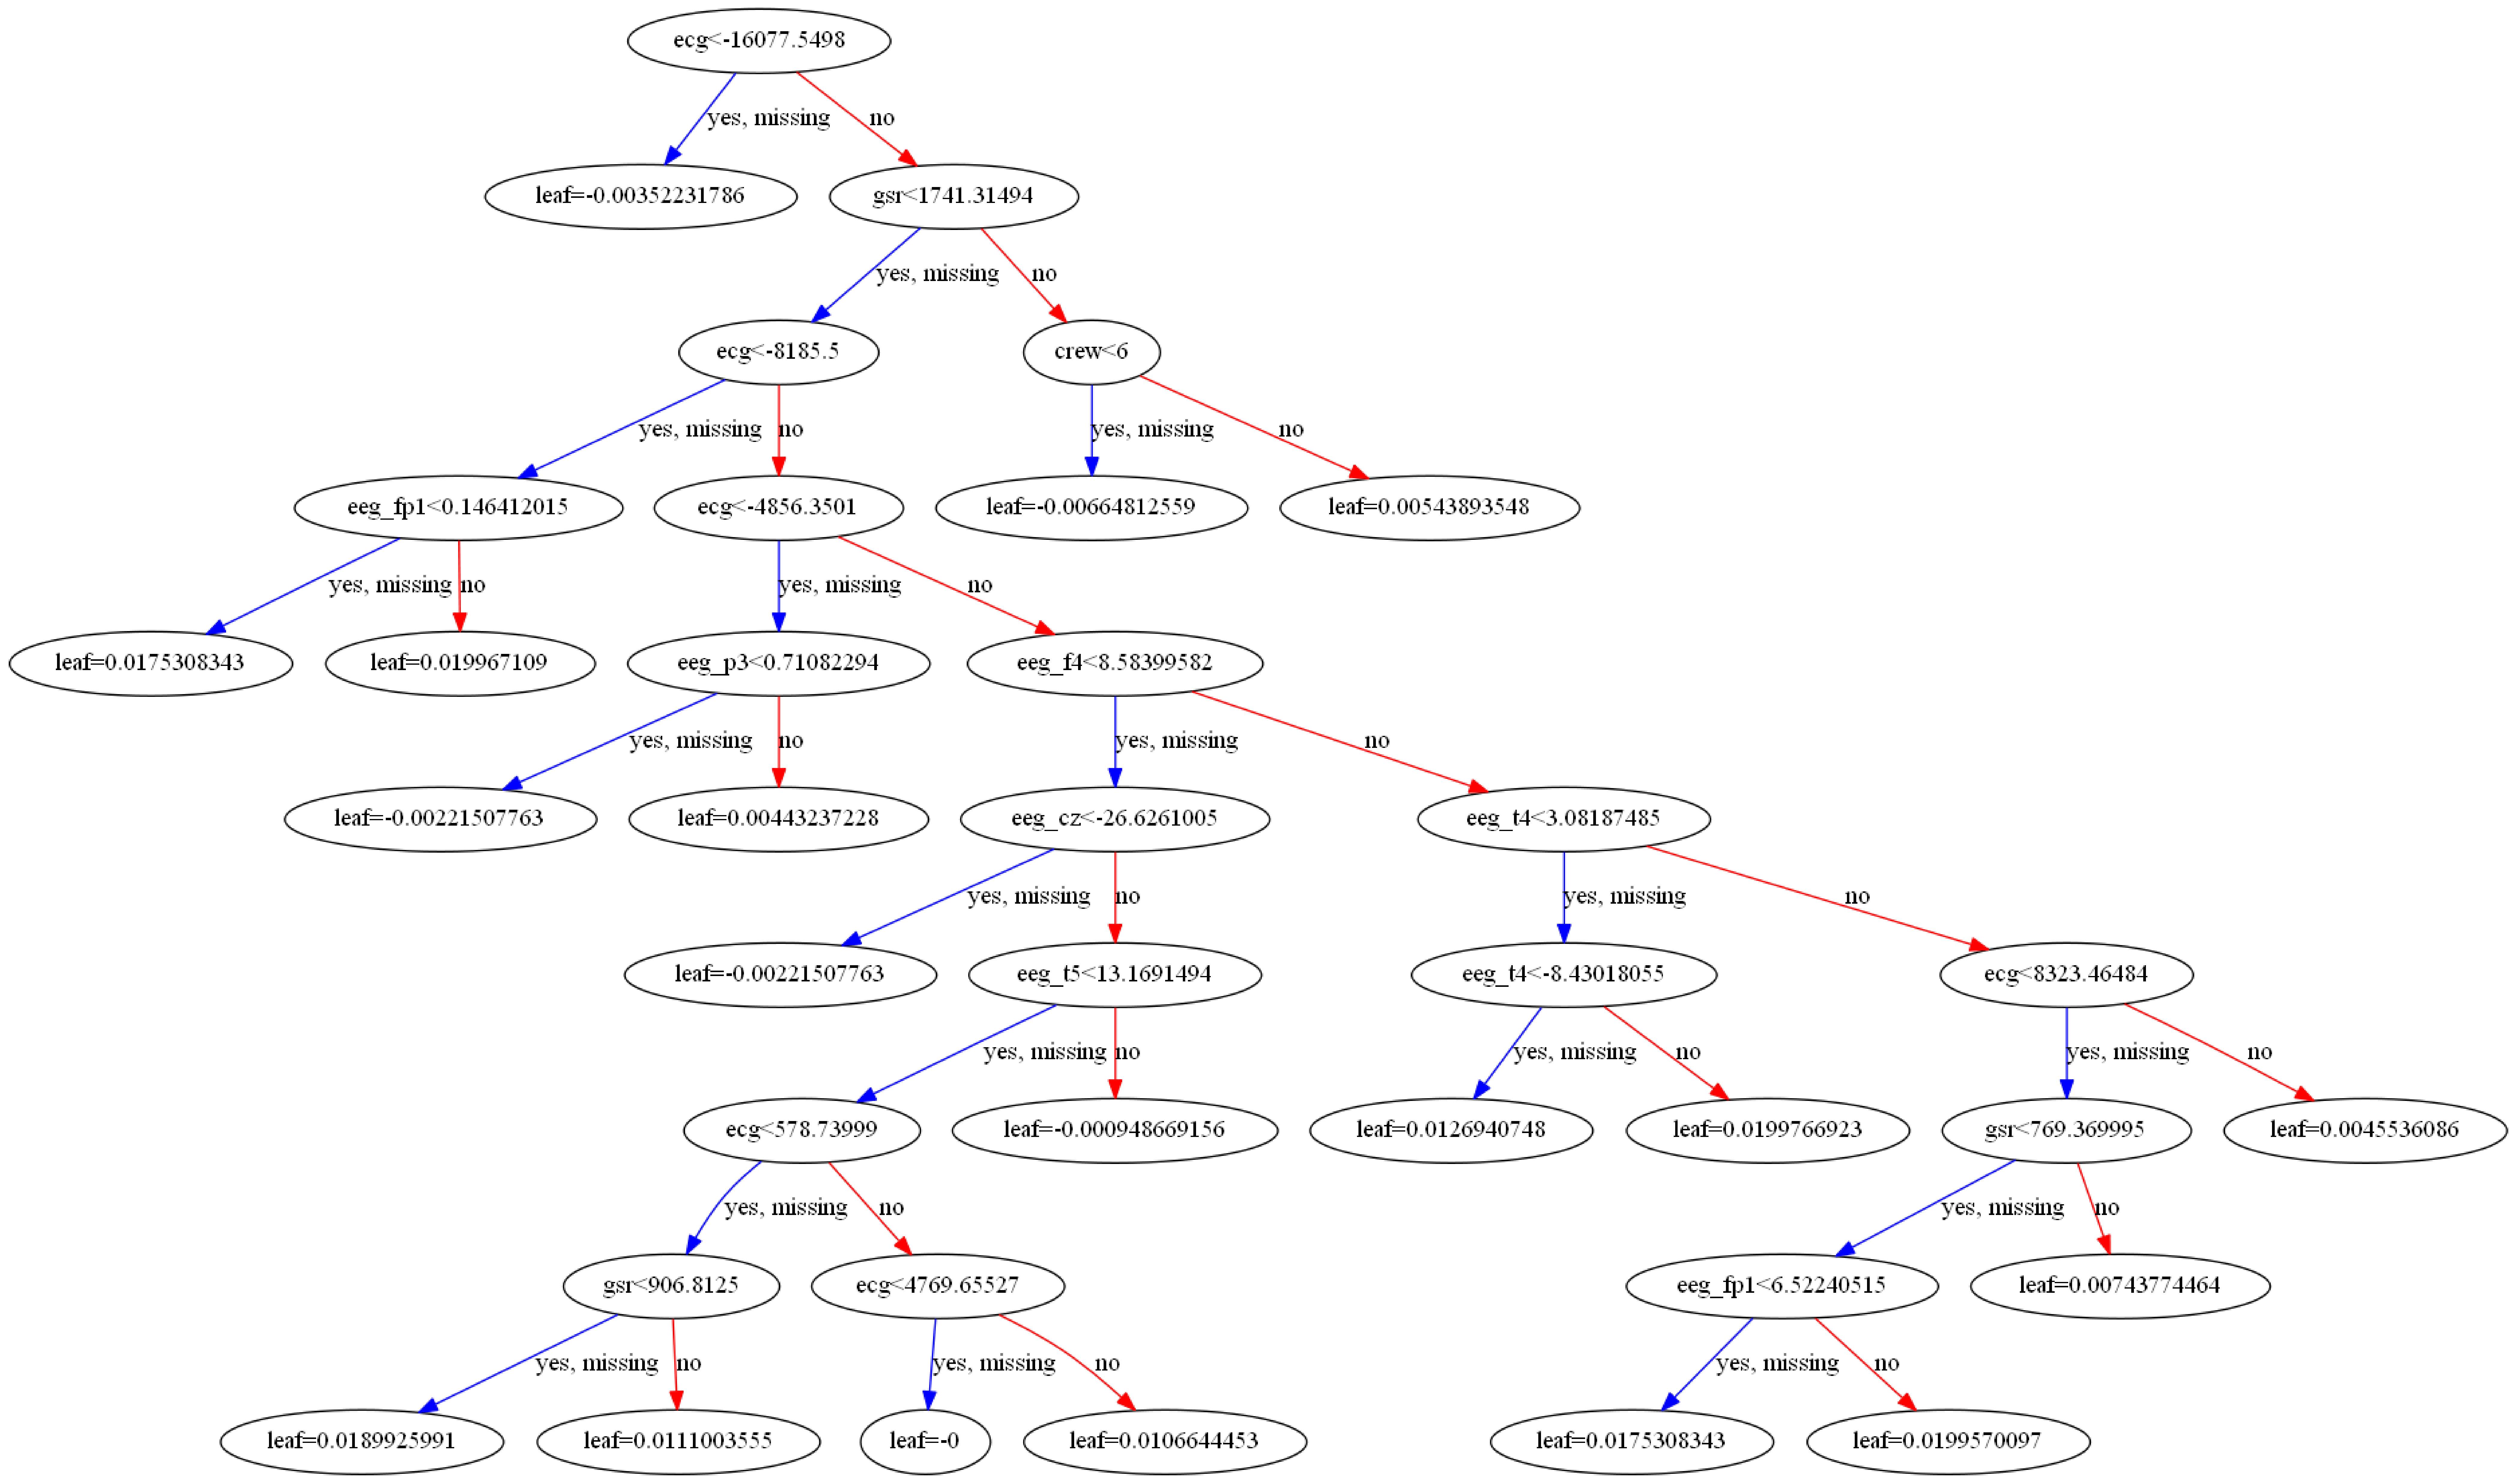

In [60]:
xgb.plot_tree(result_classifier_subsample)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig("tree0_subsample.jpeg")
plt.show()

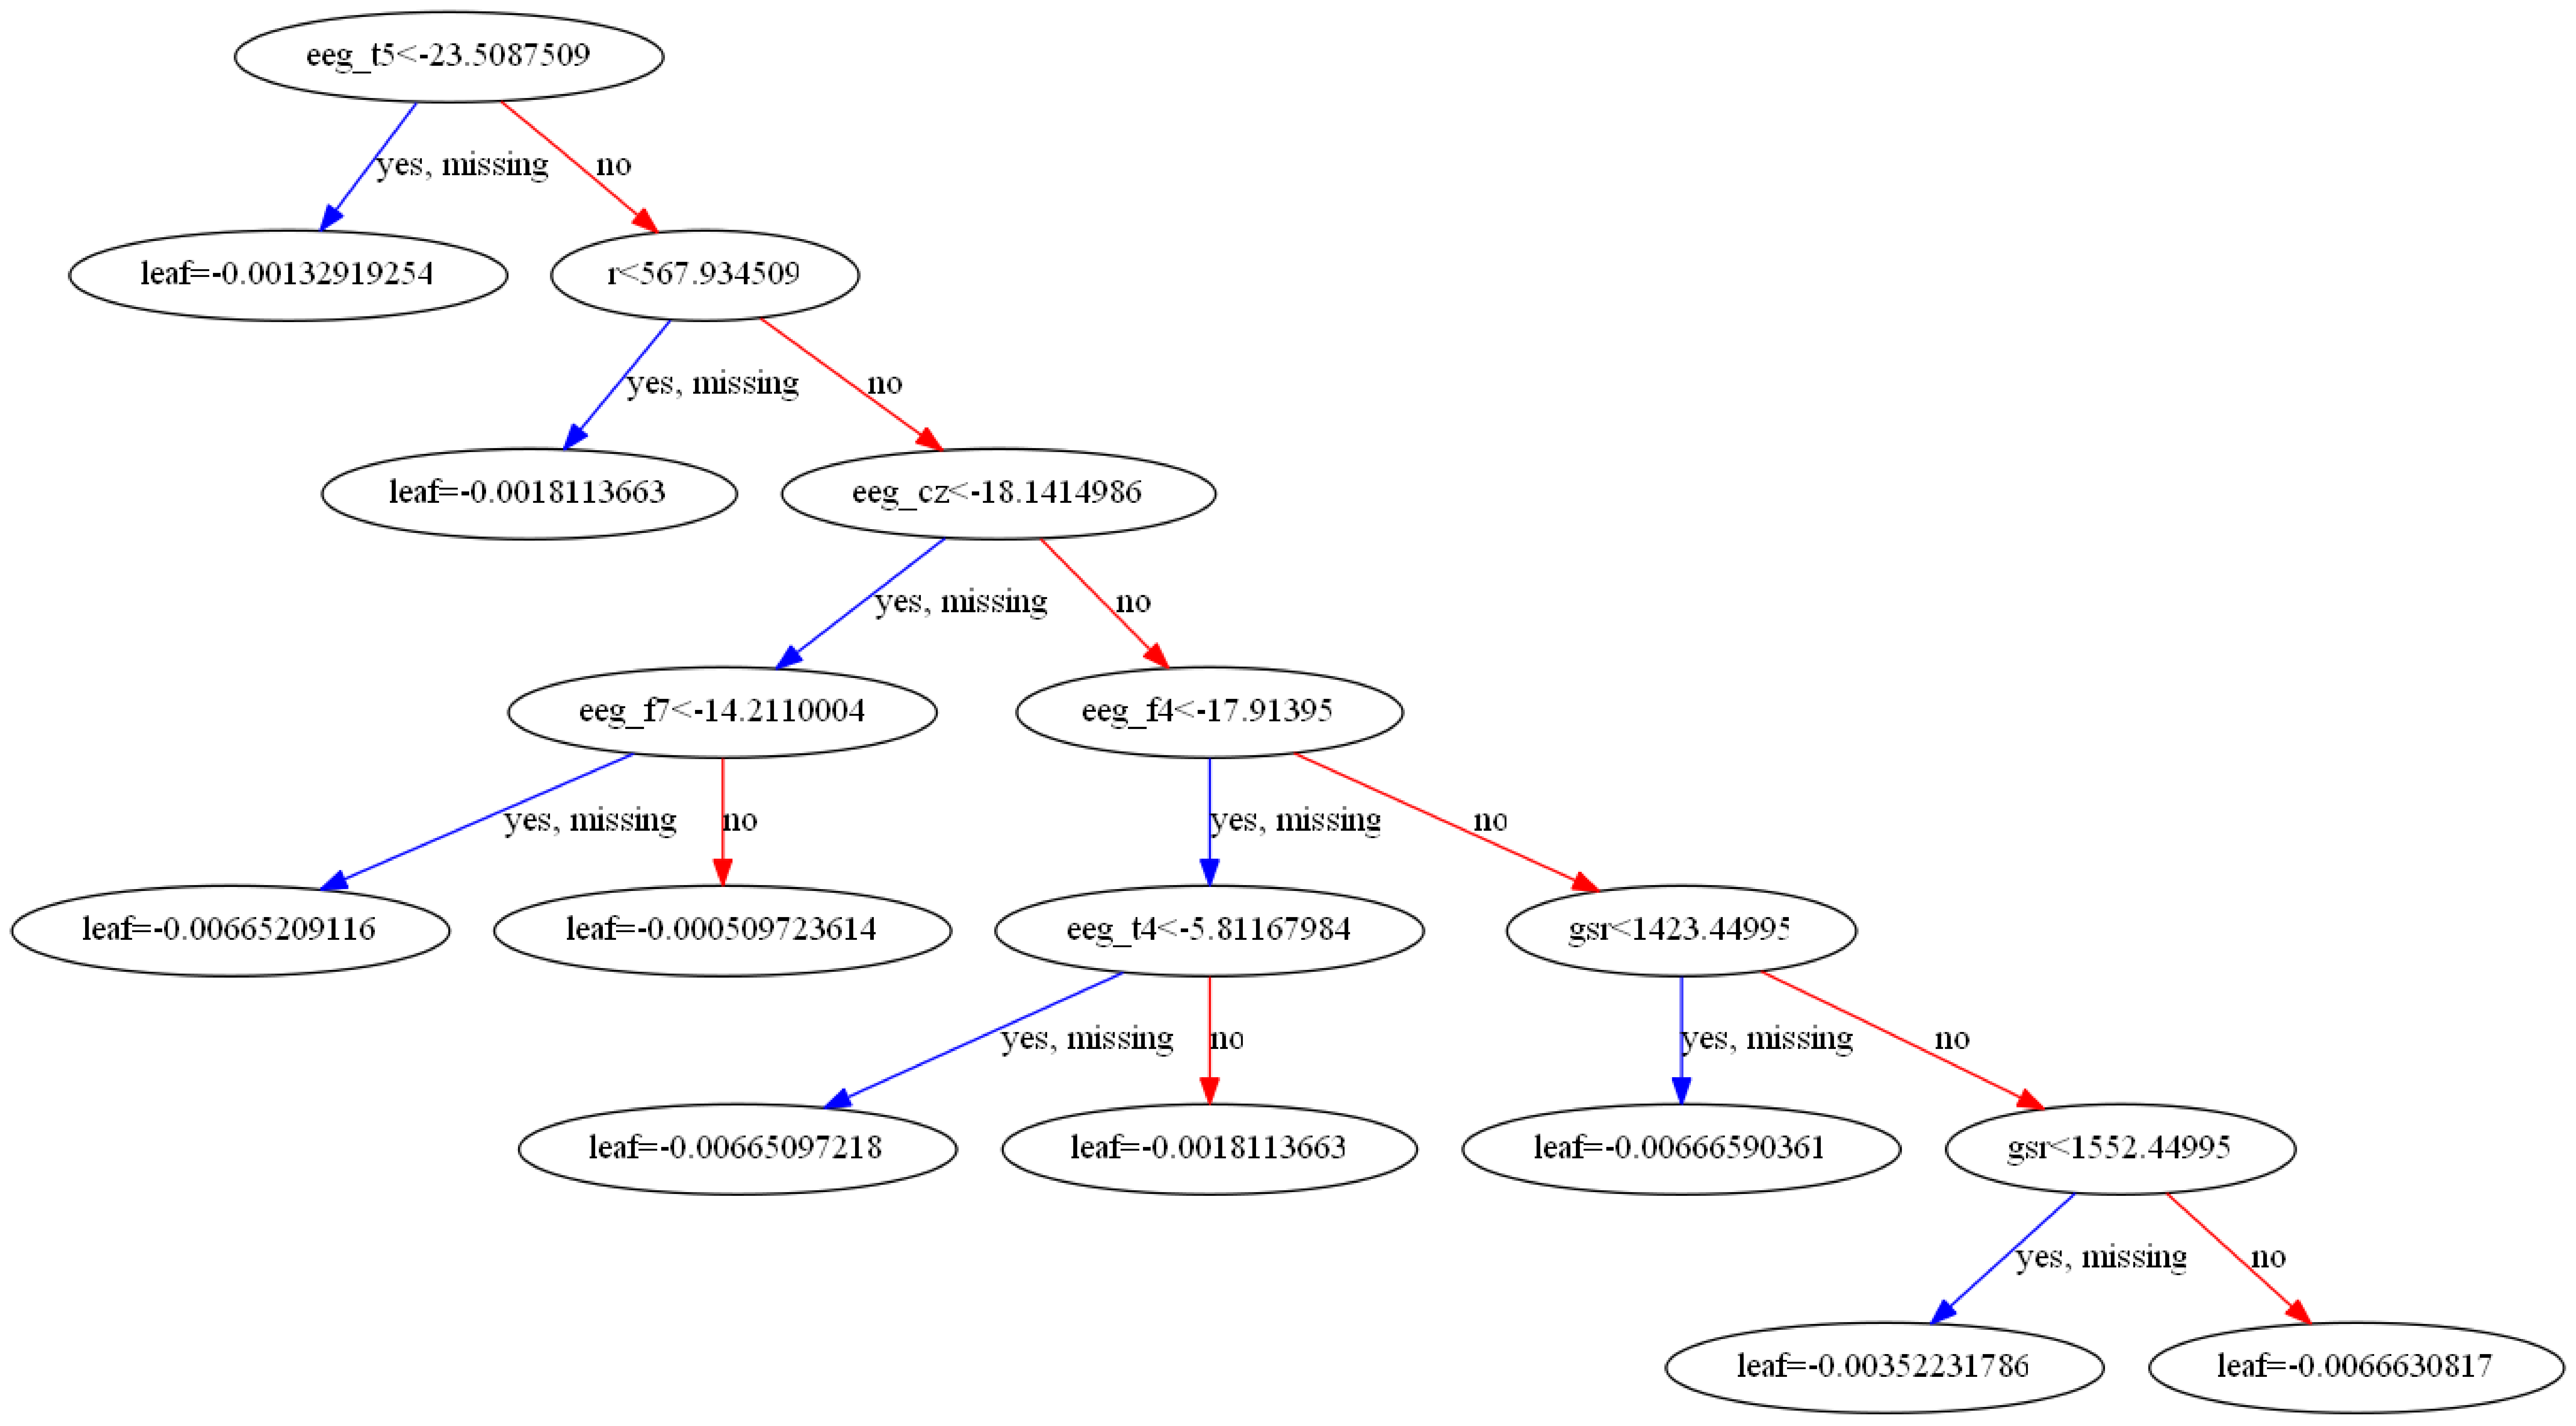

In [61]:
xgb.plot_tree(result_classifier_subsample, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig("tree1_subsample.jpeg")
plt.show()

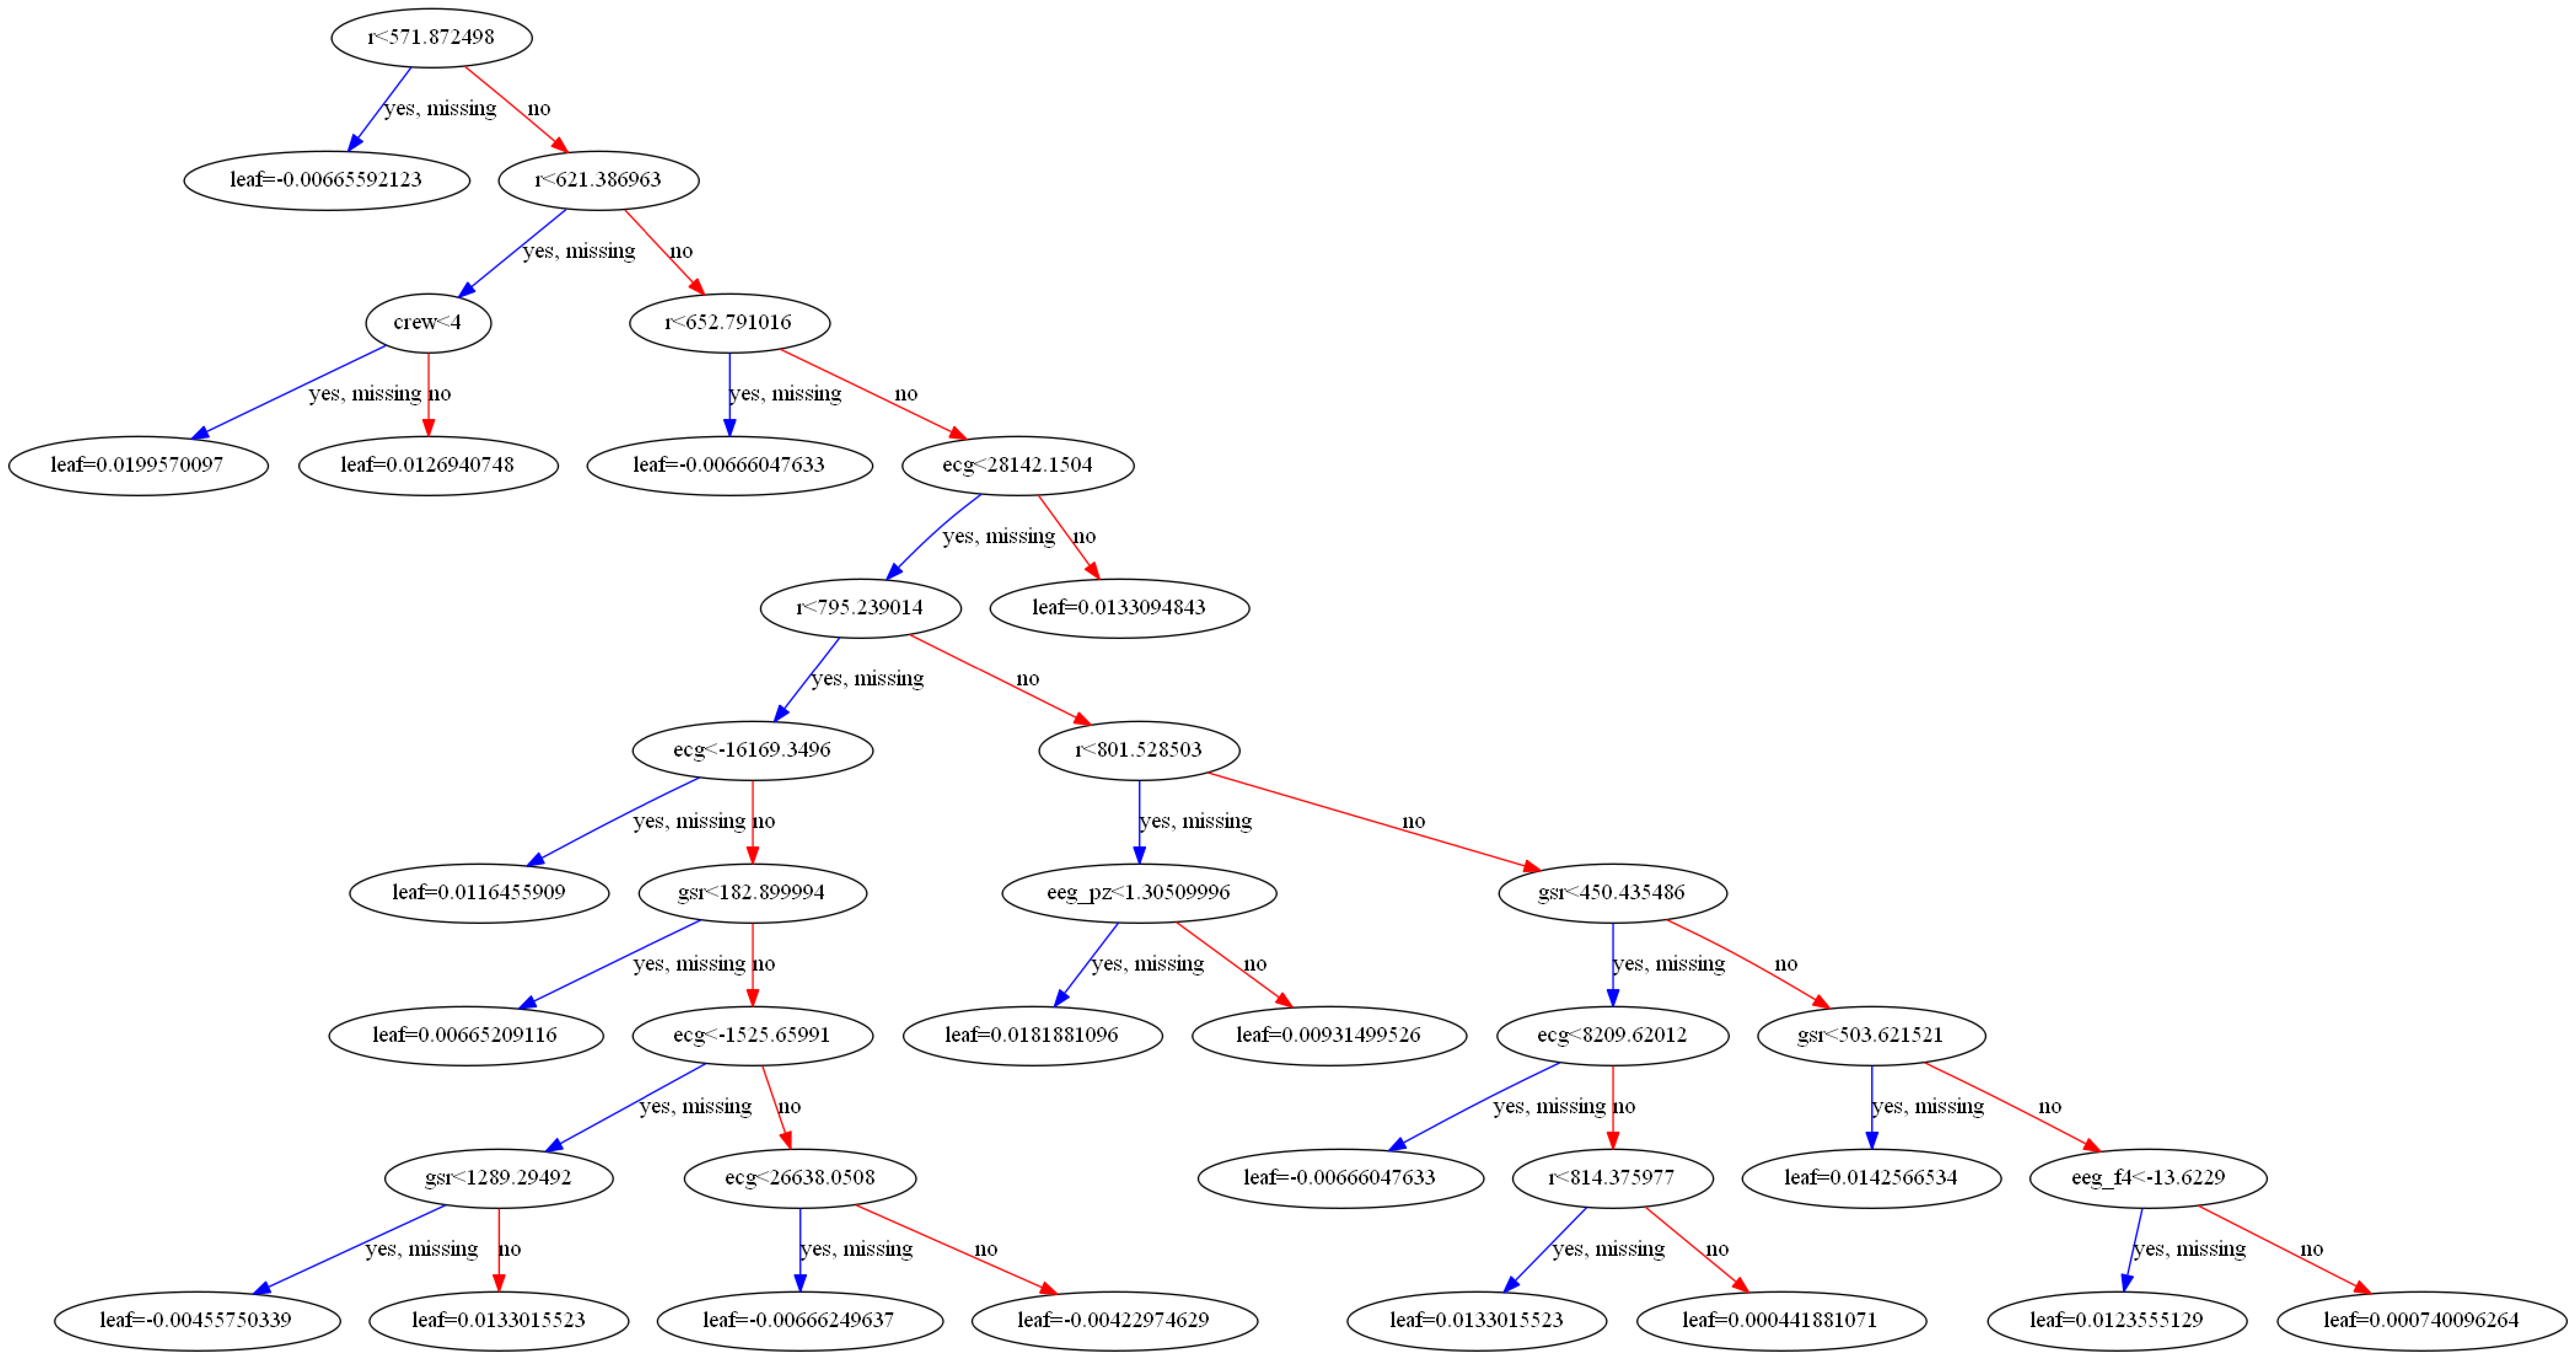

In [62]:
xgb.plot_tree(result_classifier_subsample, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig("tree2_subsample.jpeg")
plt.show()

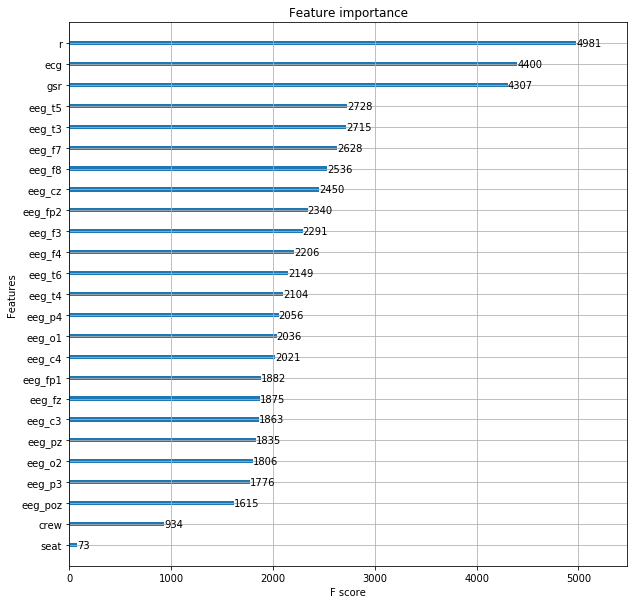

In [76]:
xgb.plot_importance(result_classifier_subsample, show_values=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
#plt.savefig("tree.jpeg")
plt.show()